### Udacity - Machine Learning Nanodegree - Capstone Project: (Mar. 2018) ###

#### Zachary Mccoy | __[Email](mailto:zdmc23@gmail.com)__ 

__[Transfer Learning](https://cs231n.github.io/transfer-learning/)__ enables a variety of computer vision projects without the need to train a __[Convolutional Neural Net (CNN)](https://en.wikipedia.org/wiki/Convolutional_neural_network)__ from scratch (important because the computing resources required to do so are often available to large institutions only). Today, most Transfer Learning projects rely on a few specific datasets (e.g., __[ImageNet](http://image-net.org)__) which have proven to be useful, but which are limited to specific domains. The goal of this Notebook is to explore the feasibility of creating pre-trained models which are domain specific, and to know whether this will significantly improve the accuracy. For example, the U.S.-based National Institute of Health (NIH) has released a [dataset](#section-datasets) of labeled chest x-rays, and it should be possible to improve classification accuracy on this dataset and/or similar datasets by first creating a "baseline" set of pre-trained weights which could be applied to classification, detection, localization efforts which involve x-ray images. This is a __[Supervised Learning](https://en.wikipedia.org/wiki/Supervised_learning)__ project.

Based on the somewhat lackluster results of the Transfer Learning investigation, and inspired by Stanford ML Group's __[CheXNet](https://stanfordmlgroup.github.io/projects/chexnet/)__, I also decided to train a DenseNet [1] network to perform binary classification on the same NIH chest x-ray [dataset](#section-datasets), albeit on a single category ("Pulmonary Fibrosis"). In this case, the binary classification is a one-vs-all (a.k.a. __[one-vs-rest](https://en.wikipedia.org/wiki/Multiclass_classification#One-vs.-rest)__) approach for the lung disease category: "Pulmonary Fibrosis"; samples from this single class are taken against a random sample of the other 14 categories (including "No Finding"). This approach seemed to have achieved near state of the art results, with an __[AUROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve)__ of far greater than 0.05 of previously published results [2]. Due to my surprise, I immediately gathered another distinct chest x-ray dataset ([Indiana University](#section-datasets) - IU), which also included Pulmonary Fibrosis examples, and I tested that dataset. The model failed terribly!

I have made the [weights](#section-weights) publicly available, I have published my DenseNet implementation details as a __[public Kaggle Kernel](https://www.kaggle.com/zdmc23/nihdensenet/)__, and I have also developed a Web Service (__https://zdmc.info/pulmonary-fibrosis__) to test individual samples from different datasets, and to experiment with Dynamically Expandable Networks (DENs) [3].

 1. Huang, et. al. (2016). Densely Connected Convolutional Networks. https://arxiv.org/abs/1711.05225
 1. Rajpukar, et. al. (2017). CheXNet: Radiologist-Level Pneumonia Detection on Chest X-Rays with Deep Learning, 4. https://arxiv.org/abs/1711.05225
 1. Lee, et. al. (2017). Lifelong Learning with Dynamically Expandable Networks. https://arxiv.org/abs/1708.01547v2

#### OVERVIEW ####

- [Environment](#section-environment)
- [Datasets](#section-datasets)
- [Preprocessing the Dataset](#section-preprocess)
- [Selecting the Model](#section-selecting-the-model)
- [Transfer Learning Results](#section-results)
- [Weights](#section-weights)

#### MODEL ####

- [Loading the Model](#section-loading-the-model)
- [Create new "top" layer](#section-top-layer)
- [Save weights (sans "top" layer)](#section-save-weights-no-top)
- [Compile the Model](#section-compile)
- [Callbacks](#section-callbacks)
- [Load Dataset (in-memory)](#section-load-data-memory)
- [Load Dataset (batches)](#section-load-data-batches)
- [Train the Model](#section-train)
- [Visualize training history](#section-visualize-training-history) (optional)
- [Save/Load Weights or Model](#section-save-load-weights-model) (optional)

#### EVALUATION ####

- [Model Evaluation](#section-model-evaluation)
- [Predictions](#section-predictions)
- [Confusion Matrix](#section-confusion-matrix)
- [Confidence](#section-model-confidence)

#### VISUALIZATIONS ####

- [Visualize predictions](#section-visualize-predictions)
- [Visualize convolution (layer output)](#section-visualize-layer-output)
- [Visualize weights and filters](#section-visualize-weights-filters)

#### FINDINGS AND ANALYSIS ####

- [Lessons learned](#section-lessons-learned)
- [Potential improvements](#section-potential-improvements)

#### DENSENET ####

- [OvA Pulmonary Fibrosis](#section-densenet)

<a id="section-environment"></a>
#### Environment ####

- conda 4.3.30
- Python 3.6.3
- TensorFlow 1.4.1
- Keras 2.1.3
- bcolz 1.1.2
- Keras-viz 0.4.1
- numpy 1.13.3
- matplotlib 2.1.0
- PIL 1.1.6
- scipy 0.19.1
***
- GNU/Linux "convert" via ImageMagick 6.8.9-9
***
- [Amazon AWS (p2.xlarge) GPU instance](https://aws.amazon.com/ec2/instance-types/p2/) (Nvidia Tesla K80, GK210GL)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import os
import glob
import math
import random
from keras.preprocessing.image import load_img, img_to_array

img_path="data/images/"
img_height=224 #299
img_width=224 #299
num_classes = 15 #2

# credit: https://github.com/fastai/fastai/blob/9e9ffbd49eb6490bb1168ce2ff32b10a81498ba9/fastai/utils.py
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]


def get_image(img,display=False):
    # if 'img' is a NumPy array, then it has already been loaded; just show it
    if type(img).__module__ == np.__name__:
        return img
    else:
        image = load_img(img, target_size=(img_width, img_height)) #, grayscale=True)
        #image = Image.open(img_path).convert("L")
        #image = image.resize((img_height,img_width), Image.ANTIALIAS)
        return np.asarray(image)
    
def get_image_batch(img,display=False):
    image_arr = get_image(img,display)
    if display == True:
        plt.figure()
        plt.imshow(image_arr)
        plt.show()
    return np.expand_dims(image_arr,axis=0)

def plot_img(img, title, count, cols, plot_axis=False):
    a = fig.add_subplot(1, cols, count)
    # if 'img' is a NumPy array, then it has already been loaded; just show it
    if type(img).__module__ == np.__name__:
        plt.imshow(img)
    else:
        plt.imshow(load_img(img))
    a.set_title(title,fontsize=10)
    if plot_axis is False:
        plt.axis('off')

/home/ubuntu/anaconda2/envs/dl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda2/envs/dl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


<a id="section-datasets"></a>
#### Datasets ####

- NIH: Dataset is comprised of 112,120 X-ray images with disease labels (15 classes) from 30,805
unique patients. 2017. 
    - https://nihcc.app.box.com/v/ChestXray-NIHCC
    - https://www.kaggle.com/nih-chest-xrays
    - https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community
- NLM: Tuberculosis – Montgomery. X-ray images in this dataset have been acquired from the
tuberculosis control program of the Department of Health and Human Services of Montgomery County,
MD, USA. This set contains 138 posterior-anterior x-rays, of which 80 x-rays are normal and 58 x-rays
are abnormal with manifestations of tuberculosis. 
    - https://ceb.nlm.nih.gov/repositories/tuberculosis-chest-x-ray-image-data-sets/
    - https://openi.nlm.nih.gov/imgs/collections/NLM-MontgomeryCXRSet.zip
- NLM : Tuberculosis – Shenzhen. X-ray images in this dataset have been collected by Shenzhen No.3
Hospital in Shenzhen, Guangdong providence, China. There are 340 normal x-rays and 275 abnormal
x-rays showing various manifestations of tuberculosis
    - https://ceb.nlm.nih.gov/repositories/tuberculosis-chest-x-ray-image-data-sets/
    - http://openi.nlm.nih.gov/imgs/collections/ChinaSet_AllFiles.zip
-  Indiana University Chest X-ray Collection. Kohli MD, Rosenman M - (2013). 7470 chest x-rays with both Frontal and Lateral figures. 21 of the Frontal images are labelled as "Pulmonary Fibrosis"
    - https://openi.nlm.nih.gov/imgs/collections/NLMCXR_png.tgz

<a id="section-preprocess"></a>
#### Preprocessing the Dataset ####

*Python script auto-create directories for each of the disease categories, and create symlinks for each image under the appropriate disease category (per Data_Entry_2017.csv). This assumes that the NIH dataset has been downloaded and the various image zip files (images_001.zip through images_012.zip) have been unzip'd to "data/images"* 

In [12]:
import csv

def create_label_directories(csv_filename, img_path):
    directories = set()
    with open(csv_filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(csvfile) # skip header row
        for row in reader:
            img_filename = str(row[0])
            labels = str(row[1])
            for label in labels.split('|'):
                #if label == "Hernia":
                    #continue
                src_file = os.path.join(img_path,img_filename)
                label = "_".join(label.split())
                dst_train_dir = os.path.join(img_path,"train",label)
                dst_train_file = os.path.join(dst_train_dir,img_filename)
                dst_valid_dir = os.path.join(img_path,"valid",label)
                dst_test_dir = os.path.join(img_path,"test",label)
                try:
                    if not os.path.exists(dst_train_dir):
                        os.makedirs(dst_train_dir)
                        directories.add(label)
                    if not os.path.exists(dst_valid_dir):
                        os.makedirs(dst_valid_dir)
                    if not os.path.exists(dst_test_dir):
                        os.makedirs(dst_test_dir)
                    src_file_abs = os.path.join(os.getcwd(),src_file)
                    dst_train_file_abs = os.path.join(os.getcwd(),dst_train_file)
                    #print("copy: " + src_file_abs + " to: " + dst_train_file_abs)
                    os.symlink(src_file_abs, dst_train_file_abs)
                except FileNotFoundError:
                    print("FileNotFoundError: " + src_file)
                else:
                    None
    return list(directories)

print(img_path)
directories = create_label_directories("data/Data_Entry_2017.csv", img_path)
print(directories)

data/images/
['Effusion', 'Emphysema', 'Pneumonia', 'Cardiomegaly', 'Pneumothorax', 'Mass', 'Infiltration', 'No_Finding', 'Nodule', 'Consolidation', 'Atelectasis', 'Edema', 'Fibrosis', 'Hernia', 'Pleural_Thickening']


In [13]:
def get_per_label_count(directories):
    per_label_count = []
    for ii in range(len(directories)):
        path, dirs, files = os.walk(os.path.join(img_path,"train",directories[ii])).__next__()
        file_count = len(files)
        per_label_count.append(file_count)
    return per_label_count
        
print(directories)
per_label_count = get_per_label_count(directories) 
print(per_label_count)

['Effusion', 'Emphysema', 'Pneumonia', 'Cardiomegaly', 'Pneumothorax', 'Mass', 'Infiltration', 'No_Finding', 'Nodule', 'Consolidation', 'Atelectasis', 'Edema', 'Fibrosis', 'Hernia', 'Pleural_Thickening']
[13317, 2516, 1431, 2776, 5302, 5782, 19894, 60361, 6331, 4667, 11559, 2303, 1686, 227, 3385]


*The __split_train_valid_test__ method is a helper method which enables us to move (randomly) a configurable amount of samples to populate our validation and/or test sets. By first populating the training set and then randomly moving a subset to valid/test we can ensure that we're selecting from a uniform distribution w.r.t. our training data*

In [15]:
import shutil

def split_train_valid_test(directories, per_label_count, valid_pct, test_pct):
    for ii in range(len(directories)):
        all_img_paths = glob.glob(os.path.join(img_path,"train",directories[ii],"*.*"))
        np.random.shuffle(all_img_paths)
        label_count = per_label_count[ii]
        valid_count = int(label_count*valid_pct)
        valid_files = all_img_paths[:valid_count]
        all_img_paths[:valid_count] = []
        test_count = int(label_count*test_pct)
        test_files = all_img_paths[:test_count]
        all_img_paths[:test_count] = []
        #print(len(valid_files))
        #print(len(test_files))
        train_files = all_img_paths
        all_img_paths = []
        #print(len(train_files))
        for valid_file in valid_files:
            valid_file_abs = os.path.join(os.getcwd(),valid_file)
            #print("move: '" + valid_file_abs + "' to: '" + os.path.join(img_path,"valid",directories[ii]))
            shutil.move(valid_file_abs, os.path.join(img_path,"valid",directories[ii]))
        for test_file in test_files:
            test_file_abs = os.path.join(os.getcwd(),test_file)
            #print("move: '" + test_file_abs + "' to: '" + os.path.join(img_path,"test",directories[ii]))
            shutil.move(test_file_abs, os.path.join(img_path,"test",directories[ii]))
        
print(directories)
print(per_label_count)
valid_pct = 0.1
test_pct = 0.1       
split_train_valid_test(directories, per_label_count, valid_pct, test_pct)

['Effusion', 'Emphysema', 'Pneumonia', 'Cardiomegaly', 'Pneumothorax', 'Mass', 'Infiltration', 'No_Finding', 'Nodule', 'Consolidation', 'Atelectasis', 'Edema', 'Fibrosis', 'Hernia', 'Pleural_Thickening']
[13317, 2516, 1431, 2776, 5302, 5782, 19894, 60361, 6331, 4667, 11559, 2303, 1686, 227, 3385]


- __[batch-crop-resize.sh](batch-crop-resize.sh)__ - bash script to batch crop the input dataset, and copy output to a new directory
    - `convert $img_path -gravity Center -crop 75%\! -resize 224x224 $processed_dir/$new_filename`

An example of the batch crop that was applied to all input images in order to better "focus" on the lungs (as opposed to clavicles, top of vertebral column, medical wires, and sometimes print/writing). The more isolated the lung, the better. As we will see in the [visualization](#section-visualize-layer-output) of the convolutional layer output using the ImageNet weights, often activations occur in image locations that have nothing to do with these particular disease categories (i.e., activation on the chest bone, or a medical device). More on this in [Potential improvements](#section-potential-improvements)

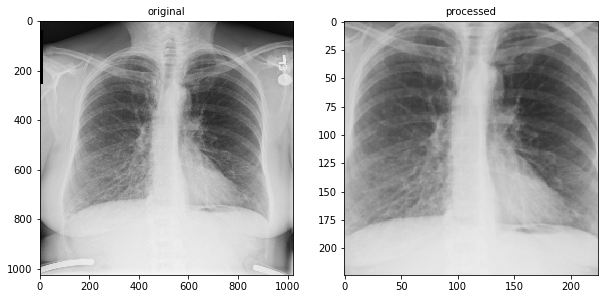

In [2]:
fig = plt.figure(figsize=(10,10))
plot_img("notebook/00001998_000.png","original",1,2,True)
plot_img("notebook/00001998_000-p.png","processed",2,2,True)
plt.show()

<a id="section-selecting-the-model"></a>
#### Selecting the Model ####

When selecting a model (or creating your own), there are some initial considerations: accuracy, sufficient complexity, performance, time required to train based on available resources, and others; these considerations are with respect to the particular input dataset size and type. 

Initial considerations for this particular project were as follows: a model which has been pre-trained on ImageNet, one which is sufficiently complex to fit the chest x-ray imagery, one that was capable of training on the full NIH dataset in under a day on an Amazon AWS P2 GPU instance, one that was available as an existing application in __[Keras](https://keras.io/)__, and (based on those considerations) a model with high accuracy (http://image-net.org/challenges/LSVRC/, https://github.com/Cadene/pretrained-models.pytorch#compute-imagenet-validation-metrics).  

I first tested with __[MobileNet](https://arxiv.org/abs/1704.04861)__ because it was created for mobile phone usage, meaning that it was designed to be resource-friendly. There is an accuracy trade off, but it was still accurate enough for our purposes (https://research.googleblog.com/2017/06/mobilenets-open-source-models-for.html). The first step was to load MobileNet pretrained with the ImageNet weights via Keras and then to "pop" the top layer and retrain a new Dense/Fully-Connected(FC) layer using a SoftMax activation function with 15 outputs (because we have 15 categories in the NIH dataset vs. 1000 categories for ImageNet). However, during retraining I was not able to achieve greater than 40% validation accuracy. At this point, I was thinking that __[Fixed Feature Extraction (FFE)](https://cs231n.github.io/transfer-learning/)__ may not be sufficient and I would need to consider Fine Tuning (removing and retraining more than just the top/final layer). Rather than guess how many layers should be retrained, I decided to simply start from "scratch" (MobileNet with randomized weights) and retrain the entire model. The results were better, but similar. It was looking like MobileNet was not sufficiently complex enough to distinguish between the subtle differences in chest x-ray images. At this point, I considered a few different custom models though they didn't result in significantly different results (when using a smaller subset of the NIH dataset). More importantly, it would not be realistic for me to attempt to retrain these custom models on the ImageNet dataset (1.2M samples) with only a single Amazon AWS P2 GPU instance. An effort like that could take weeks/months. Instead, I continued to research other models for which there were already pretrained ImageNet weights. 

I selected the __[Inception-ResNet-v2](https://arxiv.org/abs/1602.07261)__ network because it was a good balance of complexity, accuracy, and most importantly could be used to perform FFE training of the entire NIH dataset (112K samples) in less than 24 hours (with consideration for my available compute resources). ResNets allow for deeper, more complex networks, but overcome the vanishing/exploding gradient problem via "shortcut connections". For specifics on the Inception-ResNet-v2 implementation, see: https://arxiv.org/abs/1602.07261. For more information on Residual Networks in general, refer to the work of Kaiming He, et. al: https://arxiv.org/abs/1512.03385.

Because the objective was to determine whether Transfer Learning would benefit significantly from pre-training the network on a similar dataset (chest x-ray images as opposed to the more abstract ImageNet dataset), I first trained the "InceptionResNetV2" application on the Tuberculosis dataset to generate the pre-trained weights. Once I had both the ImageNet and Tuberculosis pre-trained weights, then I applied FFE to retrain only the "top"/final (Dense/Fully-Connected) layer using the NIH dataset with both weights as independent initializations.

As for the selection of the __[DenseNet](https://arxiv.org/abs/1608.06993)__ network, that was inspired by Stanford ML Group findings per __[CheXNet](https://stanfordmlgroup.github.io/projects/chexnet/)__.

<a id="section-results"></a>
#### Results ####

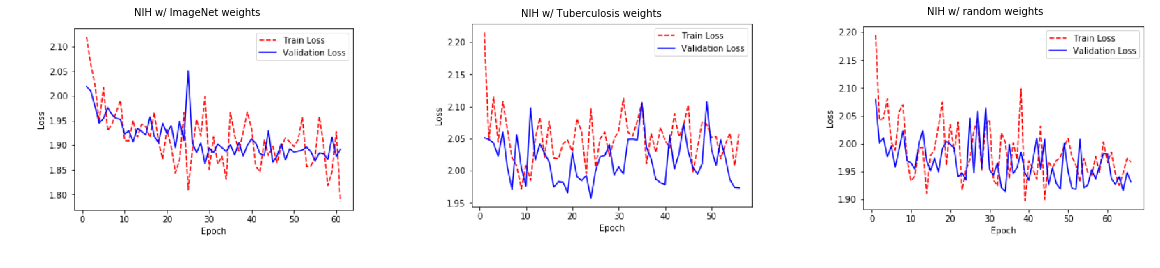

In [3]:
fig = plt.figure(figsize=(20,20))
plot_img("notebook/graph-nih-imagenet.png","NIH w/ ImageNet weights",1,3)
plot_img("notebook/graph-nih-tuberculosis.png","NIH w/ Tuberculosis weights",2,3)
plot_img("notebook/graph-nih-random.png","NIH w/ random weights",3,3)
plt.show()

To summarize the findings: if we look strictly at the results, then we observe that there is no significant difference (w.r.t. Validation Loss) between FFE on the NIH dataset with pre-trained ImageNet weights, or with pre-trained Tuberculosis weights, or even with randomized weights.

*However*, as we begin to [visualize](#section-visualize-layer-output) what is happening in these respective models, then we will better understand why it does make sense to use a similar dataset (chest x-ray images in our case) when performing this type of Transfer Learning. What we will see is that the Tuberculosis weights activate more appropriately (in the lung cavity), while the ImageNet weights often activate on more abstract features (e.g., chest bone, wires, clavicle). The problem is simply that our model is not sufficiently complex (and our input images are not sufficiently defined - we would require far higher resolution - larger input pixel sizes).

<a id="section-weights"></a>
#### Weights ####

All weights are released under the MIT license as specified by the [LICENSE](LICENSE) file

- [weights.best.inceptionResNetV2-tuberculosis.20180118_no_top.hdf5](weights.best.inceptionResNetV2-tuberculosis.20180118_no_top.hdf5)
- [weights.best.inceptionResNetV2-tuberculosis.20180118.hdf5](weights.best.inceptionResNetV2-tuberculosis.20180118.hdf5)


- [weights.best.inceptionResNetV2-nih-pretrained-random.20180118.hdf5](weights.best.inceptionResNetV2-nih-pretrained-random.20180118.hdf5)
- [weights.best.inceptionResNetV2-nih-pretrained-imagenet.20180118.hdf5](weights.best.inceptionResNetV2-nih-pretrained-imagenet.20180118.hdf5)
- [weights.best.inceptionResNetV2-nih-pretrained-tuberculosis.20180118.hdf5](weights.best.inceptionResNetV2-nih-pretrained-tuberculosis.20180118.hdf5)


- [weights.best.DenseNet121-nih-one-v-all-fibrosis.20180305.hdf5](weights.best.DenseNet121-nih-one-v-all-fibrosis.20180305.hdf5)
- [weights.best.DenseNet121-nih-one-v-all-fibrosis.20180312-3x.hdf5](weights.best.DenseNet121-nih-one-v-all-fibrosis.20180312-3x.hdf5)

<a id="section-loading-the-model"></a>
#### Loading the Model (sans "top" layer) ####

To train and/or use the model(s), we must load it into memory. Keras applications offer a parameter "include_top" which indicates whether to include the "top" layer (this is the final Dense/Fully-Connected(FC) layer with # nodes equal to # of categories that we want to classify; a "softmax" activation is then applied). For our purposes, we do not want the top layer because it presupposes an ImageNet dataset with 1000 categories. Instead, we will load the model(s) without the top layer, and then (in the Cell that follows) create a new top layer with the # of classifiers that we're training to predict. In the case of the Tuberculosis dataset, there are 2 categories (Tuberculosis, or Not Tuberculosis). In the case of the NIH dataset there are 15 disease categories, including "No Finding".

Below we are loading pre-trained weights for all 3 datasets: Random, ImageNet, and Tuberculosis. While Keras supplies the pre-trained ImageNet weights for most/all of its applications (and, of course, Random), we needed to create the Tuberculosis weights by actually training our model on these particular datasets.

A quick note about the "input_shape" of CNNs: implementations such as the "InceptionResNetV2" application that Keras provides make it a point reproduce the models as detailed in academic paper. It has been a standard practice to use images 300x300 pixels or smaller. Inception-ResNet-v2, Inception-v3, and Xception each use 299x299, while VGG16, VGG19, various ResNets, and MobileNet use 224x224. The ImageNet dataset itself is typically preprocessed and resized to 256x256 (or the size of any of the popular models just mentioned). The rationale for this size related to performance considerations (which is the same rationale for using CNNs as well). Larger images means more parameters which means far more compute resources (both computation and memory, though memory scales well at the moment). As GPUs, and potentially FPGAs or other customized chip designs evolve, then we should see larger image dimensions which should lead to more accuracy, especially in the cases of datasets like chest x-ray images where fine details are critical.

In [2]:
from keras.applications import InceptionResNetV2
model_random_topless = InceptionResNetV2(include_top=False, weights=None, input_shape=(img_width,img_height,3))
model_imagenet_topless = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(img_width,img_height,3))
model_tuberculosis_topless = InceptionResNetV2(include_top=False, weights=None, input_shape=(img_width,img_height,3))
model_tuberculosis_topless.load_weights('weights.best.inceptionResNetV2-tuberculosis.20180118_no_top.hdf5')
print(model_random_topless.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

<a id="section-top-layer"></a>
#### Create new "top" layer ####

The goal of __[Fixed Feature Extraction (FFE)](https://cs231n.github.io/transfer-learning/)__ is to reuse weights from a previously trained model (and typically a different dataset - i.e., ImageNet) and then to retrain only the top/final layer using your particular dataset. The top layer is the same structure as the previously trained model, except that our Dense/Fully-Connected(FC) layer will have an input # equal to that of our classification catorgies (15 in the case of the NIH dataset vs. the 1000 of ImageNet).

It's important to note that we're "freezing" the weights in our previously trained layers. If we don't do this, then we will be retraining any layers with unfrozen weights (the entire model in this case), and simply starting off with the previously pretrained weights (as opposed to random weights). Those weights would still be subject to update after backpropagation, and we would lose the benefits of Transfer Learning. There are some cases, with respect to Fine Tuning, where you may want to "freeze" most layers, but allow for retraining of some of the later layers, more than simply the top/final layer. In those scenarios, it could be useful to retrain previously trained weights.

If you want to re-create the Tuberculosis weights, then just swap out the Dense layer to have the proper # of classes (2 vs. 15), and do not freeze the layers.

In [3]:
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Activation, AveragePooling2D, GlobalAveragePooling2D

def create_top_layer(model, num_classes, freeze_layers=True, display_summary=False):
    if freeze_layers is True:
        for layer in model.layers:
            layer.trainable = False
    top_model = Sequential()
    top_model.add(GlobalAveragePooling2D(input_shape=model.output_shape[1:]))
    top_model.add(Dense(num_classes))
    top_model.add(Activation('softmax'))
    if display_summary is True:
        top_model.summary()
    model = Model(inputs=model.input, outputs=top_model(model.output))
    return model

model_random = create_top_layer(model_random_topless,num_classes,True,True)
model_random.load_weights('weights.best.inceptionResNetV2-nih-pretrained-random.20180118.hdf5')
model_imagenet = create_top_layer(model_imagenet_topless,num_classes)
model_imagenet.load_weights('weights.best.inceptionResNetV2-nih-pretrained-imagenet.20180118.hdf5')
model_tuberculosis = create_top_layer(model_tuberculosis_topless,num_classes)
model_tuberculosis.load_weights('weights.best.inceptionResNetV2-nih-pretrained-tuberculosis.20180118.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                23055     
_________________________________________________________________
activation_610 (Activation)  (None, 15)                0         
Total params: 23,055
Trainable params: 23,055
Non-trainable params: 0
_________________________________________________________________


<a id="section-save-weights-no-top"></a>
#### Save weights (sans "top" layer) ####

After training the model from scratch on the Tuberculosis dataset(s), we want to "pop" the top layer and save the weights. This will allow for re-loading the weights later (sans "top" layer), like we do with our ImageNet weights.

In [5]:
#model.layers.pop()
#model.summary()
#model.save_weights("weights.best.inceptionResNetV2-tuberculosis.20180118_no_top.hdf5")

<a id="section-compile"></a>
#### Compile the Model ####

Now we will compile our model in preparation for training. It's important to note that this is the place where we will be selecting many of our "tunable" hyperparameters.  

First we will select a __[Loss function](https://en.wikipedia.org/wiki/Loss_functions_for_classification)__ for classification; in our case we select a __[cross entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression)__ which is "ubiquitous in modern deep neural networks".

Next we will select an __[Optimization algorithm](http://ruder.io/optimizing-gradient-descent/)__. With the selection of a given optimizer, we also need to select values for the hyperparameters associated with each optimizer. Initially, I tried a simpler Stochastic Gradient Descent (SGD) optimizer along with a variety of "momentum" values and a variety of learning rates (including with decay). However, when the model was not converging as I had hoped. The ResNet paper authors used the RMSProp optimizer for their work, but since Adam very closely resembles RMSProp and is more commonly used in recent work, I switched to the Adam [1] optimizer. Generally speaking, it's good practice to refer to the published authors of a given optimizer and use the same hyperparameters that were used in that work. In the case of Adam, there were a few additional hyperparameters: α = 0.001, β1 = 0.9, β2 = 0.999 and ∈ = 1e-8. (Note: If you see the Cell below, you'll notice that we don't specify the 2 beta values or epsilon, and this is because Keras uses the same values provided by the published work as default values, and the TensorFlow default epsilon value is already 1e-8).

Finally, we will select the metrics that we'd like to evaluated during training; in our case we will be selecting both "accuracy" and "top_k_categorical_accuracy". "Top_K_Categorical_Accuracy" is a commonly used metric to determine whether the model successfully predicts accuracy within K places (the most common K value is 5).

 1. Kingma, D. P., & Ba, J. L. (2015). Adam: a Method for Stochastic Optimization. International Conference on Learning Representations, 1–13. https://arxiv.org/abs/1412.6980


In [4]:
from keras import optimizers, metrics
lr=0.001 #0.001 #1e-4 #0.1
#mo=0.9
decay=0.0
model_random.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=lr, decay=decay), metrics=['accuracy', metrics.top_k_categorical_accuracy])
model_imagenet.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=lr, decay=decay), metrics=['accuracy', metrics.top_k_categorical_accuracy])
model_tuberculosis.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=lr, decay=decay), metrics=['accuracy', metrics.top_k_categorical_accuracy])

<a id="section-callbacks"></a>
#### Callbacks ####

After each training __[epoch](https://www.cse.unsw.edu.au/~billw/mldict.html#epoch)__, we can enable one or more callback(s) to take some action. A common use-case is to "checkpoint" our weights IF the metric that we're measuring (i.e., validation loss) has improved. If our validation loss improves (you can specify whether you want to minimize or maximize the matric, but because it's loss, we minimize), then we will save the weights so that we can reload those at any future time that we wish to retrain; we would be starting from the "best" known weights at that time.

In our case, we've also included 2 additional callbacks: Early Stopping and TensorBoard log entries. Early Stopping is also becoming a fairly common callback for most projects. Early Stopping enables you to stop training your model early if the metric that we're measuring (also validation loss, in this case) has not improved over some N # of epochs. This is important if training may take a very long time, or if compute resources are limited. There is no use in wasting time or resources if you're model is not improving! TensorBoard has preliminary support in Keras at the time of publishing this Notebook. I am only using it as a further visualization technique, as some of the options did not work properly at the time of use.

In [24]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
filepath="weights.best.inceptionResNetV2-nih-pretrained-random.20180308.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min') #mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=32)
#tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=64, write_graph=True, write_grads=False, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
callbacks_list = [checkpoint,early_stopping]#,tensorboard]

<a id="section-load-data-memory"></a>
#### Load Dataset (in-memory) ####

When loading the dataset, we have 2 options: in-memory (as we do in the Cell below) and streaming in-batches (as we do in [Load Dataset (batches)](#section-load-data-batches)). In-memory is simpler because it helps to have a complete array containing samples and labels for later analysis (i.e., __[Predictions](#section-predictions)__). However, large datasets often prevent us from doing so due to resource constraints, so then we have a streaming in-batches option which will iteratively pull in N number of batches/samples indefinitely (though, practically you stop after training the model on the entire set of samples).

In order to build our labels, we have some helper methods which return __[one-hot](https://en.wikipedia.org/wiki/One-hot)__ encodings based on # of classes in each particular dataset.

In [5]:
def get_tuberculosis_class(img_path):
    finding = img_path.split('.')[0][-3] #[-1]
    if finding == '1':
        return [0,1]
    else:
        return [1,0]

def get_nih_class(img_path):
    class_dir = img_path.split('/')[3] #[2]
    if class_dir == 'No Finding' or class_dir == 'No_Finding':
        return [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]
    elif class_dir == 'Atelectasis':
        return [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    elif class_dir == 'Cardiomegaly':
        return [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]
    elif class_dir == 'Consolidation':
        return [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]
    elif class_dir == 'Edema':
        return [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]
    elif class_dir == 'Effusion':
        return [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]
    elif class_dir == 'Emphysema':
        return [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0]
    elif class_dir == 'Fibrosis':
        return [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]
    elif class_dir == 'Hernia':
        return [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]
    elif class_dir == 'Infiltration':
        return [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]
    elif class_dir == 'Mass':
        return [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0]
    elif class_dir == 'Nodule':
        return [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0]
    elif class_dir == 'Pleural_Thickening':
        return [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0]
    elif class_dir == 'Pneumonia':
        return [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0]
    elif class_dir == 'Pneumothorax':
        return [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]
    else:
        print("Unknown class: " + class_dir)
        return [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

def get_class(img_path, num_classes):
    if num_classes == 2:
        return get_tuberculosis_class(img_path)
    elif num_classes == 15:
        return get_nih_class(img_path)
    else:
        return []
    
def get_data(images_dir, num_classes):
    imgs = []
    labels = []
    all_img_paths = glob.glob(os.path.join(images_dir, '*/*.*'))
    np.random.shuffle(all_img_paths)
    for img_path in all_img_paths:
        imgs.append(get_image(img_path))
        labels.append(get_class(img_path, num_classes))
    return np.array(imgs), np.array(labels)

Here we pass in the path to the images to be loaded for our training set. In addition to loading the images into memory, we are also generating the corresponding label array. It depends on the dataset, but it's a standard practice to prepare your dataset to be structured such that you have: "train" and "valid" (and often a "test") directories/folders. Then you would have directories for each of your N classes (i.e., in the case of NIH, we have 15 subdirectories with names like "Fibrosis" and "Pneumonia" for each category). In the case of the Tuberculosis dataset, it's the filename that is signifying the class. If the filename ends in "0" (e.g., MCUCXR_0102_0.png), then that signifies: "No Tuberculosis". If it ends in "1", then that signifies: "Tuberculosis".  In the methods defined above, we're handling both of these cases. Other common methods of mapping categories to inputs/samples is to have a spreadsheet which contains entries with filename, categories, and other metadata. Sometimes a framework like Keras demands a particular method of mapping categories; for example, when we use the Generators (see: [Load Dataset (batches)](#section-load-data-batches), it is assumed that the input/samples will be found according to the directory structured previously described:
- train
 - Fibrosis
 - Pneumonia
 - ...
- valid
 - Fibrosis
 - Pneumonia
 - ...
- test
 - Fibrosis
 - Pneumonia
 - ...

In [66]:
#montgomery_X_train, montgomery_y_train = get_data('MontgomerySet/CXR_png/train',num_classes) 
#shenzhen_X_train, shenzhen_y_train = get_data('ChinaSet_AllFiles/CXR_png/train',num_classes) 
#X_train = np.concatenate((montgomery_X_train,shenzhen_X_train), axis=0)
#y_train = np.concatenate((montgomery_y_train,shenzhen_y_train), axis=0)
#X_train, y_train = get_data('data/images/train',num_classes) 
#print(X_train.shape)
#print(y_train.shape)
#montgomery_X_valid, montgomery_y_valid = get_data('MontgomerySet/CXR_png/valid',num_classes) 
#shenzhen_X_valid, shenzhen_y_valid = get_data('ChinaSet_AllFiles/CXR_png/valid',num_classes) 
#X_valid = np.concatenate((montgomery_X_valid,shenzhen_X_valid), axis=0)
#y_valid = np.concatenate((montgomery_y_valid,shenzhen_y_valid), axis=0)
#X_valid, y_valid = get_data('data/images/valid',num_classes)
#print(X_valid.shape)
#print(y_valid.shape)
X_test, y_test = get_data('data/images/test',num_classes) 
print(X_test.shape)
print(y_test.shape)

(14147, 224, 224, 3)
(14147, 15)


It can often take time to load large datasets into memory at once, so we make use of some helper methods (which makes use of the __[bcolz](http://bcolz.blosc.org/en/latest/intro.html)__ library) to serialize NumPy arrays to disk and then later read them from disk back into memory. This is especially useful if you find yourself restarting the Jupyter Notebook __[Kernel](https://jupyter.readthedocs.io/en/latest/glossary.html#term-kernel)__ and you don't want to re-run the code to load the training set and corresponding labels; instead you can simply load the saved array representations from disk.

In [67]:
#save_array('nih-X_train.bc', X_train)
#save_array('nih-y_train.bc', y_train)
#save_array('nih-X_valid.bc', X_valid)
#save_array('nih-y_valid.bc', y_valid)
save_array('nih-X_test.bc', X_test)
save_array('nih-y_test.bc', y_test)

In [6]:
#X_train = load_array('nih-X_train.bc')
#y_train = load_array('nih-y_train.bc')
#X_valid = load_array('nih-X_valid.bc')
#y_valid = load_array('nih-y_valid.bc')
X_test = load_array('nih-X_test.bc')
y_test = load_array('nih-y_test.bc')

<a id="section-load-data-batches"></a>
#### Load Dataset (batches) ####

When loading the dataset, we have 2 options: streaming in-batches (as we do in the Cell below) and in-memory (as we do in [Load Dataset (in-memory)](#section-load-data-memory)). For more information on how "generators" work in Keras, see: https://keras.io/preprocessing/image/ and https://github.com/keras-team/keras/blob/master/keras/preprocessing/image.py

Generators are often very helpful for doing "real-time" __[Data Augmentation](https://www.youtube.com/watch?v=JI8saFjK84o)__. In this particular case, I did not want to perform some of the more common data augmentation (with respect to computer vision) techniques (i.e., mirroring) because I am not expert enough to understand whether certain of these diseases manifest in particular lung geographies (i.e., nearly always in the left lung). In hindsight, I suppose some techniques like shearing may be appropriate; however there are other improvements which would be likely to have greater impact before that sort of data augmentation - more on that in [Potential improvements](#section-potential-improvements)

In [5]:
from keras.preprocessing.image import ImageDataGenerator
#from keras.applications.inception_resnet_v2 import preprocess_input

train_datagen = ImageDataGenerator(
    rescale=1./255#,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True, 
    #preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    rescale=1./255#,
    #preprocessing_function=preprocess_input
)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
    os.path.join(img_path,'train'),
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical')#,
    #color_mode='grayscale')

validation_generator = test_datagen.flow_from_directory(
    os.path.join(img_path,'valid'),
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical')#,
    #color_mode='grayscale')
    
test_generator = test_datagen.flow_from_directory(
    os.path.join(img_path,'test'),
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 113243 images belonging to 15 classes.
Found 14147 images belonging to 15 classes.
Found 14147 images belonging to 15 classes.


<a id="section-train"></a>
#### Train the Model ####

Now we're finally ready to train our model! 
 
With each passing epoch, backpropogation occurs and the weights are updated. You can choose to have a single epoch which covers every single sample in your training set, and then update the weights, and repeat this N times, or you can have many epochs with batches of your training set, and then update the weights many times, and repeat this until your entire training set is covered, or covered more than once (although covering your training set more than once provides marginal improvement). There has been some research regarding which is a better practice ("It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize."), and for more on that see: https://arxiv.org/abs/1609.04836. Due to GPU memory limitations, you often don't have the choice to load all samples in a single batch, and research shows it's not helpful, so it's a good rule of thumb to simply plan for # epochs to be equal to # of training samples divided by batch_size (commonly 32). Then if you want to make multiple passes though the training set, you multiple that by the # of passes (commonly less than 10 passes will provide desired convergence). For our purposes we take a small batch size with many epochs (size of training set divided by batch size) for AT LEAST full coverage of our training set.

In [ ]:
nb_train_samples = 113243
nb_validation_samples= 14147  
epochs = int(nb_train_samples/batch_size)*2 #1
history = model_random.fit_generator(
    train_generator,
    steps_per_epoch=batch_size, #nb_train_samples/batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=batch_size, #nb_validation_samples/val_batch_size,
    callbacks=callbacks_list,
    verbose=1)
#batch_size = 32
#history = model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(X_valid,y_valid),callbacks=callbacks_list,verbose=1)#,steps_per_epoch=int(nb_train_samples/batch_size),validation_steps=int(nb_validation_samples/val_batch_size))

Epoch 1/1
32/32 [==============================] - 43s 1s/step - loss: 2.0377 - acc: 0.4102 - top_k_categorical_accuracy: 0.7627 - val_loss: 2.6927 - val_acc: 0.0918 - val_top_k_categorical_accuracy: 0.7627

Epoch 00001: val_loss improved from inf to 2.69267, saving model to weights.best.inceptionResNetV2-nih-pretrained-random.20180308.hdf5


<a id="section-visualize-training-history"></a>
#### Visualize training history (optional) ####

Keras records a History of training which is accessible as the output of the "fit" or "fit_generator" methods (https://keras.io/models/sequential/#fit). "Its 'History.history' attribute is a record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values (if applicable)". We can then plot the training and validation loss to gain an intuition about whether our model is overfitting (low train loss, high valid loss; most common), underfitting (high train loss; need more complexity in the model), or generalizing as desired (low train loss, low valid loss).

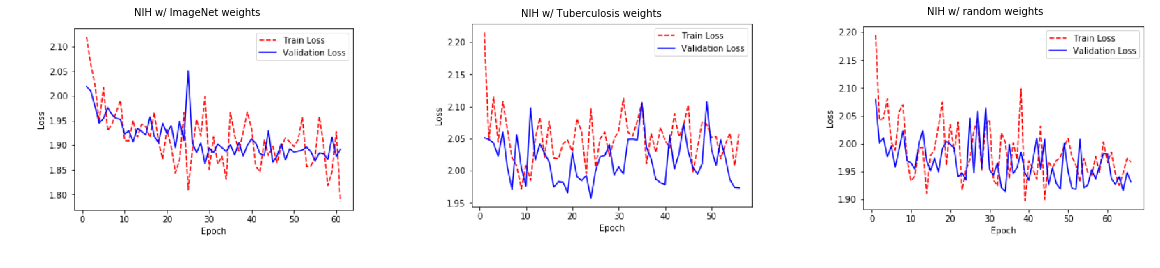

In [6]:
def plot_history(history):
    plt.plot(history.history['loss'],'r--')
    plt.plot(history.history['val_loss'],'b-')
    plt.title('Model Loss')
    plt.legend(['Train Loss', 'Valid Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();
    plt.plot(history.history['acc'],'r--')
    plt.plot(history.history['val_acc'],'b-')
    plt.title('Model Accuracy')
    plt.legend(['Train Acc', 'Valid Acc'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

# requires history=model.fit, fit_generator...
#plot_history(history)

fig = plt.figure(figsize=(20,20))
plot_img("notebook/graph-nih-imagenet.png","NIH w/ ImageNet weights",1,3)
plot_img("notebook/graph-nih-tuberculosis.png","NIH w/ Tuberculosis weights",2,3)
plot_img("notebook/graph-nih-random.png","NIH w/ random weights",3,3)
plt.show()

<a id="section-save-load-weights-model"></a>
#### Save/Load Weights or Model ####

We have to option to save our weights only, or we can save the entire model. Weights are useful for scenarios like Transfer Learning, as exhibited in [Create new "top" layer](#section-top-layer). However, if we'd like to simply load our entire model for run-time predictions, then we can do this as well. File size doesn't actually differ much between saving the weights vs. the entire model, as the bulk of the information is the weight matrices. It's important to note that it is often unnecessary to manually save our weights as we are "checkpointing" the "best" weights during training (see: [Callbacks](#section-callbacks)).

In [10]:
# save weights only
#model.save_weights('weights.best.inceptionResNetV2-nih.20180118.hdf5')
# load weights only
#model.load_weights('weights.best.inceptionResNetV2-nih.20180118.hdf5')

# save entire model
#model.save('entire-nih-tuberculosis-model.h5')
# load entire model
#from keras.models import load_model
#model = load_model('entire-nih-tuberculosis-model.h5')
#model.summary()

<a id="section-model-evaluation"></a>
#### Model Evaluation ####

This is a "traditional" metric of evaluating our model; it's a reiteration of what we saw per epoch during [training](#section-train). Here we compare our various models against the validation set.

In [6]:
nb_test_samples = 14147
steps = math.ceil(nb_test_samples/batch_size)

In [7]:
print("-- RANDOM --")
scores = model_random.evaluate(X_test, y_test)
#scores = model_random.evaluate_generator(test_generator, steps=steps, max_queue_size=10, workers=1, use_multiprocessing=False)
print("score = Loss: %f, Acc@1: %.2f, Acc@5: %.2f" % (scores[0],scores[1],scores[2]))
print("-- IMAGENET --")
scores = model_imagenet.evaluate(X_test, y_test)
#scores = model_imagenet.evaluate_generator(test_generator, steps=steps, max_queue_size=10, workers=1, use_multiprocessing=False)
print("score = Loss: %f, Acc@1: %.2f, Acc@5: %.2f" % (scores[0],scores[1],scores[2]))
print("-- TUBERCULOSIS --")
scores = model_tuberculosis.evaluate(X_test, y_test)
#scores = model_tuberculosis.evaluate_generator(test_generator, steps=steps, max_queue_size=10, workers=1, use_multiprocessing=False)
print("score = Loss: %f, Acc@1: %.2f, Acc@5: %.2f" % (scores[0],scores[1],scores[2]))

-- RANDOM --
14147/14147 [==============================] - 216s 15ms/step
score = Loss: 2.563585, Acc@1: 0.17, Acc@5: 0.72
-- IMAGENET --
14147/14147 [==============================] - 215s 15ms/step
score = Loss: 5.027771, Acc@1: 0.06, Acc@5: 0.46
-- TUBERCULOSIS --
14147/14147 [==============================] - 215s 15ms/step
score = Loss: 2.569027, Acc@1: 0.14, Acc@5: 0.63


__FINDINGS:__ By simply observing the evaluation metrics, we could conclude that Transfer Learning (with similar domain pre-trained weights) is no better than using random weights in the previous layers. However, we we begin to dig deeper and [visualize](#section-visualize-cam) the results, we see that the ImageNet weights do a fairly decent job of recognizing that the feature should be within the chest cavity. Moreover, the Tuberculosis weights also activate on specific regions of the input, while the random weights are achieving that level of accuracy via nothing more than chance (as we would expect). There are also some specific improvements that could be made to improve Transfer Learning with domain specific datasets. For more on that, see: [Potential improvements](#section-potential-improvements)

- Acc@1 = Top 1; the model predicts a category with highest probability that matches the true label
- Acc@5 = Top 5; of the 5 highest probility categories predicted by the model, at least 1 matches the true label

<a id="section-predictions"></a>
#### Predictions (in-memory) ####

In [8]:
preds = model_tuberculosis.predict(X_test)
save_array('nih-tuberculosis-preds.bc', preds)

<a id="section-predictions-batches"></a>
#### Predictions (batches) ####

*Warning: 32+ GB free memory required for this operation (test set of 14147 images), and takes ~30 mins to run, unless you comment out X_test line*

In [12]:
def get_data_with_predictions(model,generator,steps,classes):
    X_test = np.zeros((0,img_height,img_width,3))
    y_test = np.zeros((0,classes))
    preds = np.zeros((0,classes))
    step_count = 0
    for batch_x, batch_y in generator:
        if step_count < steps:
            batch_preds = model.predict(batch_x)
            preds = np.vstack((preds,batch_preds))
            X_test = np.vstack((X_test,batch_x))
            y_test = np.vstack((y_test,batch_y))
            step_count = step_count + 1
        else:
            break
    return X_test, y_test, preds
   
X_test, y_test, preds = get_data_with_predictions(model_tuberculosis,test_generator,steps,num_classes)
print(X_test.shape)
print(y_test.shape)
print(preds.shape)
save_array('nih-X_test.bc', X_test)
save_array('nih-y_test.bc', y_test)
save_array('nih-tuberculosis-preds.bc', preds)

(14147, 224, 224, 3)
(14147, 15)
(14147, 15)


#### Load previous predictions (both in-memory and batch) ####

*Warning: 20+ GB free memory required for this operation (test set of 14147 images), unless you comment out X_test line*

In [ ]:
#X_test = load_array('nih-X_test.bc')
#y_test = load_array('nih-y_test.bc')
preds = load_array('nih-tuberculosis-preds.bc')
print(X_test.shape)
print(y_test.shape)
print(preds.shape)

*Print prediction counts*

In [9]:
def get_tested_predictions(y_trues, preds):
    correct_preds = []
    incorrect_preds = []
    correct_count = 0
    incorrect_count = 0
    for ii in range(len(y_trues)):
        label_idx = np.argmax(y_trues[ii])
        prediction_idx = np.argmax(preds[ii])
        prediction = preds[ii][prediction_idx]
        if prediction_idx == label_idx:
            correct_preds.append(prediction)
            incorrect_preds.append(np.nan)
            correct_count = correct_count + 1
        if prediction_idx != label_idx:
            incorrect_preds.append(prediction)
            correct_preds.append(np.nan)
            incorrect_count = incorrect_count + 1
    return correct_preds, correct_count, incorrect_preds, incorrect_count

correct_preds, correct_count, incorrect_preds, incorrect_count = get_tested_predictions(y_test,preds)
print("Correct predictions: %d/%d" % (correct_count,len(preds)))
print("Incorrect predictions: %d/%d" % (incorrect_count,len(preds)))

Correct predictions: 1995/14147
Incorrect predictions: 12152/14147


<a id="section-model-confidence"></a>
#### Confidence ####

Interquartile range (__[IQR](https://en.wikipedia.org/wiki/Interquartile_range)__) is a descriptive statistic which measures the "middle 50" of a distribution; the difference between the 75th and 25th percentiles (IQR=Q3-Q1). IQR is useful to identify outliers, which we will consider for determining a confidence metric with respect to each of the model predictions.

In [10]:
def get_outlier_threshold(percentile,factor):
    return (percentile+factor)

def get_max_predictions(preds):
    new_preds = []
    tmp = list(preds)
    for ii in range(len(preds)):
        prediction_idx = np.argmax(tmp[ii])
        prediction = preds[ii][prediction_idx]
        new_preds.append(prediction)
    return new_preds
    
def measure_confidence(prediction,preds):
    factor = 3.0
    q75, q25 = np.nanpercentile(get_max_predictions(preds), [75,25])
    print("(Q3: " + str(q75) + ", Q1: " + str(q25) + ")")
    confident_threshold = get_outlier_threshold(q75,(factor/100))
    if prediction >= confident_threshold:
        return True
    else:
        return False

#print(get_max_predictions(preds))

*Plot histograms of predictions*

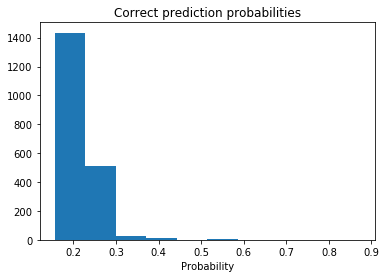

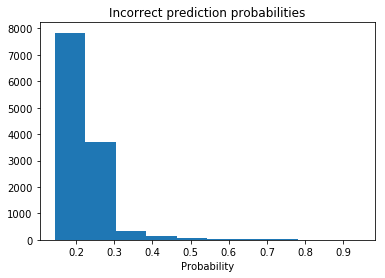

In [11]:
def plot_predictions_histogram(preds,title):
    nan_indices = np.where(~np.isnan(preds))
    preds_sin_nan = []
    nan_indices_sq = np.squeeze(nan_indices)
    for ii in range(len(nan_indices_sq)):
        preds_sin_nan.append(preds[nan_indices_sq[ii]])
    plt.figure()
    plt.hist(preds_sin_nan)
    plt.title(title)
    plt.xlabel('Probability');
    plt.show()
    
plot_predictions_histogram(correct_preds,"Correct prediction probabilities")
plot_predictions_histogram(incorrect_preds,"Incorrect prediction probabilities")

A review of the histogram of the correct predictions reveals histograms that look nearly identical, which is concerning because it could indicate that the uncertainty in predictions is roughly the same for every test input and that it's getting "lucky" ~ half the time. Also, the predictions are very *low* which could indicate some similarity in the dataset due to certain chest x-rays having multiple labels, however, in this case it is likely because we're not able to achieve the necessary level of accuracy with Transfer Learning and this particular dataset as it is.

<a id="section-confusion-matrix"></a>
#### Confusion Matrix ####

Plot a confusion matrix to help evaluate the quality of our model classification; by plotting our predictions against the true labels, we can observe whether there are particular classes which are repeatedly being misclassified.

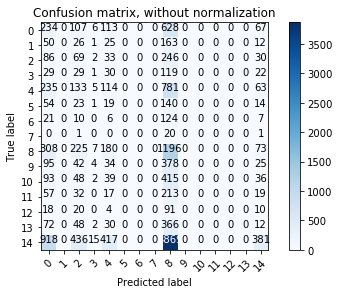

In [12]:
import itertools
from sklearn.metrics import confusion_matrix

y_trues = [np.argmax(ii) for ii in y_test]
y_preds = [np.argmax(ii) for ii in preds]

# credit: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #if normalize:
        #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(y_trues, y_preds)
class_names=list(set(np.concatenate((y_trues,y_preds),axis=0)))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
plt.show()

By observing the confusion matrix, we discover that the model is not even making predictions for over half of the possible classes! As we dig deeper, we begin to notice the effect of an "unbalanced" dataset; of the 6 classes that are being predicted, 4/6 are the categories with the most # of samples:

Label | Class | # of samples
 1. 14 | No_Finding | 60361
 1. 8  | Infiltration | 19894
 1. 4  | Effusion | 13317
 1. 0  | Atelectasis | 11559
 
Much more on "balancing" the dataset in [Potential improvements](#section-potential-improvements). As for the other predicted labels (2-Consolidation and 3-Edema), I am not sure why 3-Edema is being predicted, but it's happening significantly less than the other 5 labels, so I'll ignore it for now.  Rather, I'll focus on 2-Consolidation, which seems to be an outlier since we cannot simply attribute prediction results due to bias of # of training samples like the other 4 labels. This becomes clearer when we visualize the predictions using the "Quick 5" method; when plotting #3 "The most correct (i.e., those with highest probability that are correct)" and #4 "The most incorrect (i.e., those with highest probability that are incorrect)", we notice a pattern: wires, lots of wires present in the chest x-ray images. A quick scan through the training data reveals that "Consolidation" x-rays do have significantly higher presence of of wires, and this appears to be a feature that our model is learning. That may actually be a legitimate feature when compared to the other classes collectively, but it becomes a problem when comparing with a category like "No_Finding". "Consolidation" may be a good candidate for a OvO (one-vs-one) binary classification against "No_Finding".

<a id="section-visualize-predictions"></a>
#### Visualize predictions ####

After reviewing some of the overall statistics regarding model performance, let's drill down and try to gain further insights into which types of samples may be causing the most difficulty for our model (in hopes to make corrections and retrain the model in a more effective manner). This is especially helpful when we notice certain abnormalities in our results.

In [13]:
def classify(label):
    if label == 14:
        return 'No Finding'
    elif label == 0:
        return 'Atelectasis'
    elif label == 1:
        return 'Cardiomegaly'
    elif label == 2:
        return 'Consolidation'
    elif label == 3:
        return 'Edema'
    elif label == 4:
        return 'Effusion'
    elif label == 5:
        return 'Emphysema'
    elif label == 6:
        return 'Fibrosis'
    elif label == 7:
        return 'Hernia'
    elif label == 8:
        return 'Infiltration'
    elif label == 9:
        return 'Mass'
    elif label == 10:
        return 'Nodule'
    elif label == 11:
        return 'Pleural_Thickening'
    elif label == 12:
        return 'Pneumonia'
    elif label == 13:
        return 'Pneumothorax'
    else:
        return 'Unknown'
    
def pretty_print_predictions(idx, y_valid, preds): 
    true_label = np.argmax(y_valid[idx])
    print("True label: " + str(true_label) + " - " + classify(true_label))
    predicted_label = np.argmax(preds[idx])
    print("Pred label: " + str(predicted_label) + " - " + classify(predicted_label))
    prediction = preds[idx][predicted_label]
    print("Prediction: " + str(prediction))
    print("Confident?: " + str(measure_confidence(prediction,preds)))
    top_5 = preds[idx].argsort()[-5:][::-1]
    print("Top 5 labels: " + str(top_5))
    count = 1
    for label in top_5:
        print(str(count) + ". " + classify(label))
        count = count + 1

*Load a random sample*

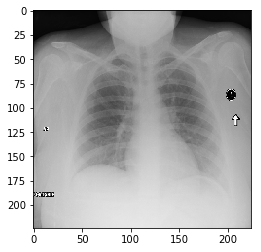

(1, 224, 224, 3)

True label: 14 - No Finding
Pred label: 8 - Infiltration
Prediction: 0.24463587
(Q3: 0.2351372316479683, Q1: 0.19247613102197647)
Confident?: False
Top 5 labels: [8 0 2 9 4]
1. Infiltration
2. Atelectasis
3. Consolidation
4. Mass
5. Effusion


In [14]:
from random import randint

def get_random_image(X_data):
    idx = randint(0,len(X_data)-1)
    return get_image_batch(X_data[idx],True), idx
    
image_batch, idx = get_random_image(X_test)
print(image_batch.shape)
print()
pretty_print_predictions(idx,y_test,preds)

__Quick 5__

Credit: Jeremy Howard, Fast.ai (https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson2.ipynb)

 1. A few correct at random
 1. A few incorrect at random
 1. The most correct (i.e., those with highest probability that are correct)
 1. The most incorrect (i.e., those with highest probability that are incorrect)
 1. The most uncertain (i.e., those with probability closest to 0.5)
 
In our scenario (multi-class classification), #5 is not applicable because a probability of ~0.5 might indicate a very confident prediction based on 15 different classes.

In [16]:
def choose_at_random(preds, num):
    tmp = list(preds)
    indices = set()
    count = 0
    while len(indices) < num:
        choice = random.choice(list(enumerate(tmp)))
        if np.isnan(choice[1]):
            continue;
        else:
            indices.add(choice[0])
            count = count + 1
    return list(indices)

def choose_most(preds,num):
    tmp = list(preds)
    for ii in range(len(tmp)):
        if np.isnan(tmp[ii]):
            tmp[ii]=0
    return list(np.argsort(tmp)[-num:][::-1]);

def plot_a_few(X_test, y_trues, preds, indices):
    for ii in range(len(indices)):
        image_batch = get_image_batch(X_test[indices[ii]],True)
        print()
        pretty_print_predictions(indices[ii],y_test,preds)

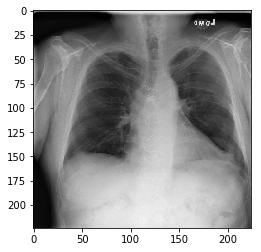


True label: 8 - Infiltration
Pred label: 8 - Infiltration
Prediction: 0.17790824
(Q3: 0.2351372316479683, Q1: 0.19247613102197647)
Confident?: False
Top 5 labels: [ 8  0  4  2 14]
1. Infiltration
2. Atelectasis
3. Effusion
4. Consolidation
5. No Finding


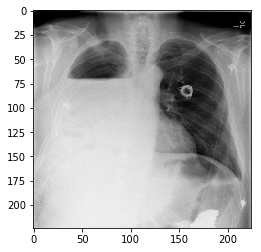


True label: 4 - Effusion
Pred label: 4 - Effusion
Prediction: 0.17848268
(Q3: 0.2351372316479683, Q1: 0.19247613102197647)
Confident?: False
Top 5 labels: [4 0 8 2 9]
1. Effusion
2. Atelectasis
3. Infiltration
4. Consolidation
5. Mass


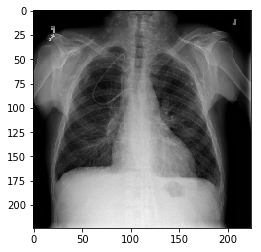


True label: 8 - Infiltration
Pred label: 8 - Infiltration
Prediction: 0.23750612
(Q3: 0.2351372316479683, Q1: 0.19247613102197647)
Confident?: False
Top 5 labels: [8 0 2 4 9]
1. Infiltration
2. Atelectasis
3. Consolidation
4. Effusion
5. Mass


In [17]:
# 1. A few correct labels at random
plot_a_few(X_test, y_test, preds, choose_at_random(correct_preds,3))

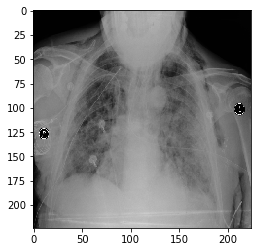


True label: 13 - Pneumothorax
Pred label: 0 - Atelectasis
Prediction: 0.22481972
(Q3: 0.2351372316479683, Q1: 0.19247613102197647)
Confident?: False
Top 5 labels: [ 0  8  4  2 14]
1. Atelectasis
2. Infiltration
3. Effusion
4. Consolidation
5. No Finding


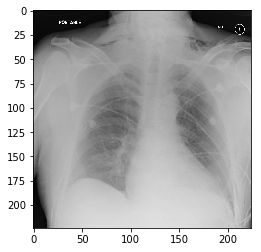


True label: 14 - No Finding
Pred label: 8 - Infiltration
Prediction: 0.1958454
(Q3: 0.2351372316479683, Q1: 0.19247613102197647)
Confident?: False
Top 5 labels: [ 8 14  4  0  2]
1. Infiltration
2. No Finding
3. Effusion
4. Atelectasis
5. Consolidation


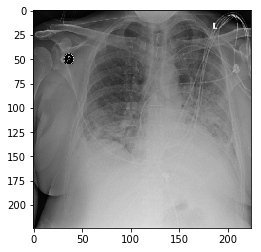


True label: 14 - No Finding
Pred label: 8 - Infiltration
Prediction: 0.22034462
(Q3: 0.2351372316479683, Q1: 0.19247613102197647)
Confident?: False
Top 5 labels: [8 2 0 4 9]
1. Infiltration
2. Consolidation
3. Atelectasis
4. Effusion
5. Mass


In [18]:
# 2. A few incorrect labels at random
plot_a_few(X_test, y_test, preds, choose_at_random(incorrect_preds,3))

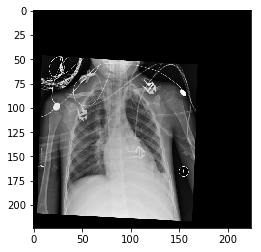


True label: 2 - Consolidation
Pred label: 2 - Consolidation
Prediction: 0.87132645
(Q3: 0.2351372316479683, Q1: 0.19247613102197647)
Confident?: True
Top 5 labels: [2 8 9 0 4]
1. Consolidation
2. Infiltration
3. Mass
4. Atelectasis
5. Effusion


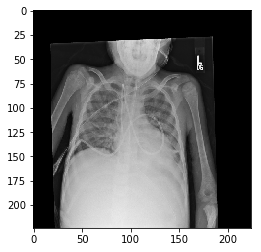


True label: 2 - Consolidation
Pred label: 2 - Consolidation
Prediction: 0.6759882
(Q3: 0.2351372316479683, Q1: 0.19247613102197647)
Confident?: True
Top 5 labels: [2 8 3 4 0]
1. Consolidation
2. Infiltration
3. Edema
4. Effusion
5. Atelectasis


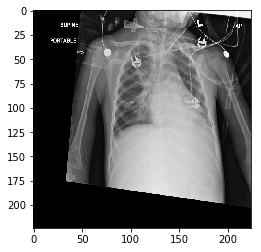


True label: 2 - Consolidation
Pred label: 2 - Consolidation
Prediction: 0.6373572
(Q3: 0.2351372316479683, Q1: 0.19247613102197647)
Confident?: True
Top 5 labels: [2 3 8 0 9]
1. Consolidation
2. Edema
3. Infiltration
4. Atelectasis
5. Mass


In [19]:
# 3. The most correct (i.e., those with highest probability that are correct)
plot_a_few(X_test, y_test, preds, choose_most(correct_preds,3))

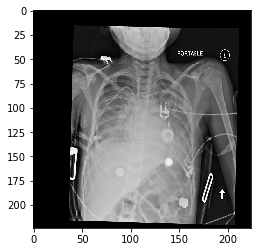


True label: 3 - Edema
Pred label: 2 - Consolidation
Prediction: 0.9419628
(Q3: 0.2351372316479683, Q1: 0.19247613102197647)
Confident?: True
Top 5 labels: [2 3 8 9 0]
1. Consolidation
2. Edema
3. Infiltration
4. Mass
5. Atelectasis


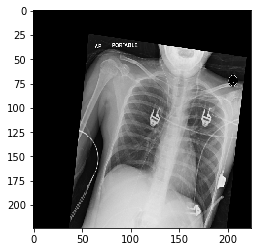


True label: 8 - Infiltration
Pred label: 2 - Consolidation
Prediction: 0.9361313
(Q3: 0.2351372316479683, Q1: 0.19247613102197647)
Confident?: True
Top 5 labels: [2 3 8 0 9]
1. Consolidation
2. Edema
3. Infiltration
4. Atelectasis
5. Mass


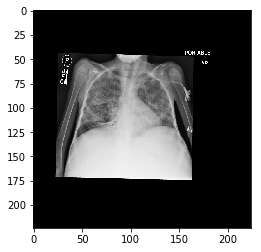


True label: 8 - Infiltration
Pred label: 2 - Consolidation
Prediction: 0.92577565
(Q3: 0.2351372316479683, Q1: 0.19247613102197647)
Confident?: True
Top 5 labels: [2 8 9 0 3]
1. Consolidation
2. Infiltration
3. Mass
4. Atelectasis
5. Edema


In [21]:
# 4. The most incorrect (i.e., those with highest probability that are incorrect)
plot_a_few(X_test, y_test, preds, choose_most(incorrect_preds,3))

<a id="section-visualize-layer-output"></a>
#### Visualize Classification Activation Mapping (CAM) (of the "top"/final Conv layer) ####

- Zhou et al. proposed a technique called Class Activation Mapping (CAM): "A class activation map for a particular category indicates the discriminative image regions used by the CNN to identify that category ... This enables classification-trained CNNs to learn to perform object localization, without using any bounding box annotations. Class activation maps allow us to visualize the predicted class scores on any given image, highlighting the discriminative object parts detected by the CNN." [1] This highlighting technique is very useful in order to understand *why* the model may be classifying an input into a given category. In the example below, it is helpful to see that the model with pre-trained ImageNet weights is activating on the sternum and area below the chest cavity boundaries (exactly what we do NOT want). Whereas, the Tuberculosis and NIH (from scratch) models are highlighting within the chest cavity (as you would expect for this particular dataset).
- We make use of Grad-CAM, "a generalization of CAM and is applicable to a significantly broader range of CNN model families", proposed by Selvaraju, et. al. (https://arxiv.org/abs/1610.02391)
- Credit: Raghavendra Kotikalapudi for providing a Keras implementation of Grad-CAM (and much more) with the Keras Vis project: https://github.com/raghakot/keras-vis

 1. B. Zhou, A. Khosla, L. A., A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. In CVPR, 2016.

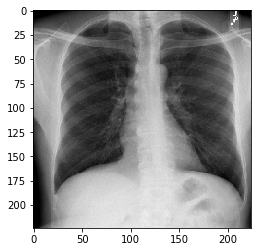

(1, 224, 224, 3)

-- RANDOM --


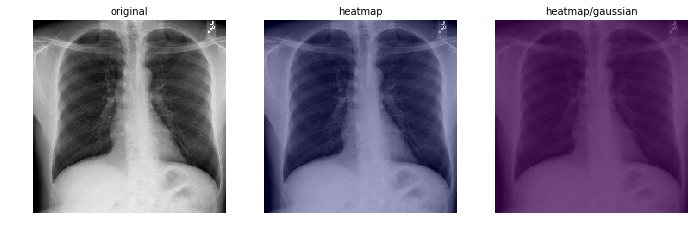

-- IMAGENET --


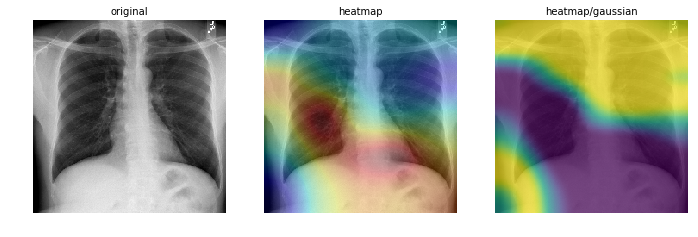

-- TUBERCULOSIS --


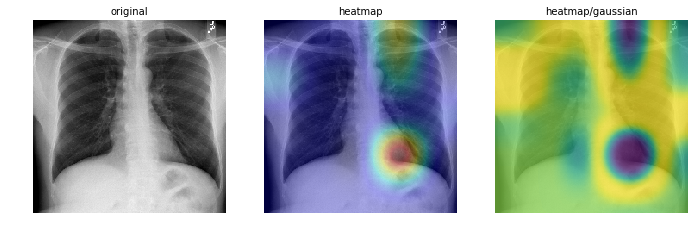

In [43]:
# WARNING! If you run any Cell with K.set_learning_rate(ANY_VALUE), then this Cell will error with the following: 
# "TypeError: Cannot interpret feed_dict key as Tensor: Can not convert a int into a Tensor."

from vis.visualization import visualize_saliency, visualize_cam, visualize_activation, overlay

def visualize_top_convolution(model,image_batch):
    layer_idx=-1
    #print(model.layers[layer_idx].name)

    # credit: https://github.com/raghakot/keras-vis/blob/master/applications/self_driving/visualize_attention.ipynb
    heatmap = visualize_cam(model, layer_idx=-1, filter_indices=None, seed_input=image_batch, grad_modifier='small_values')
    #heatmap = visualize_saliency(model, layer_idx=-1, filter_indices=None, seed_input=image_batch, grad_modifier='small_values')
    #activations = visualize_activation(model, layer_idx=-1, filter_indices=[10])

    img = image_batch.squeeze()

    # credit: (gaussian filter for a better UI) http://bradsliz.com/2017-12-21-saliency-maps/
    import scipy.ndimage as ndimage
    smooth_heatmap = ndimage.gaussian_filter(heatmap[:,:,2], sigma=5)
    #smooth_activations = ndimage.gaussian_filter(activations[:,:,2], sigma=5)

    nn = 5
    fig = plt.figure(figsize=(20,20))
    a = fig.add_subplot(1, nn, 1)
    plt.imshow(img)
    a.set_title("original",fontsize=10)
    plt.axis('off')
    a = fig.add_subplot(1, nn, 2)
    plt.imshow(overlay(img, heatmap, alpha=0.7))
    a.set_title("heatmap",fontsize=10)
    plt.axis('off')
    a = fig.add_subplot(1, nn, 3)
    plt.imshow(img)
    plt.imshow(smooth_heatmap, alpha=0.7)
    a.set_title("heatmap/gaussian",fontsize=10)
    plt.axis('off')
    #a = fig.add_subplot(1, nn, 4)
    #plt.imshow(overlay(img, activations, alpha=0.7))
    #a.set_title("activations",fontsize=10)
    #plt.axis('off')
    # better to show with entire model (including "top")
    #a = fig.add_subplot(1, nn, 5)
    #plt.imshow(img)
    #plt.imshow(smooth_activations, alpha=0.7)
    #a.set_title("activations/guassian",fontsize=10)
    #plt.axis('off')
    plt.show()

image_batch, _ = get_random_image(X_test)
print(image_batch.shape)
print()
print("-- RANDOM --")
visualize_top_convolution(model_random_topless,image_batch)
print("-- IMAGENET --")
visualize_top_convolution(model_imagenet_topless,image_batch)
print("-- TUBERCULOSIS --")
visualize_top_convolution(model_tuberculosis_topless,image_batch)

<a id="section-visualize-weights-filters"></a>
#### Visualize weights and filters (of 1st Conv layer) ####

- Now that we see what is taking place w.r.t. the model classification activation, we can gain further insights by taking a look at the other "end" of our model: the 1st convolutional layer. It is a common strategy with CNNs to visualize the weights. "These are usually most interpretable on the first CONV layer which is looking directly at the raw pixel data... The weights are useful to visualize because well-trained networks usually display nice and smooth filters without any noisy patterns. Noisy patterns can be an indicator of a network that hasn’t been trained for long enough, or possibly a very low regularization strength that may have led to overfitting." (https://cs231n.github.io/understanding-cnn/)
- The visualization below is a representation of the output of the 1st Convolutional layer (both weights and filters). This is useful to understand the relationship between model features and inputs. If you compare the output of the weights and filters for the model with the pre-trained Tuberculosis weights vs. the model with the ImageNet weights, you will notice that the features associated with the ImageNet weights seem to be associated with the more abstract object of the chest cavity overall, whereas the model with the pre-trained Tuberculosis weights tends to be "excited" within the chest cavity (as you would expect for this dataset).
- For a common alternative visualization technique, see the DeConvolution approach proposed by Zeiler, et. al: "[Zeiler, et. al.] introduce a visualization technique that reveals the input stimuli that excite individual feature maps at any layer in the model. It also allows us to observe the evolution of features during training and to diagnose potential problems with the model. The visualization technique we propose uses a multi-layered Deconvolutional Network (deconvnet) to project the feature activations back to the input pixel space." [1]

 1. Zeiler, M., Taylor, G., and Fergus, R. Adaptive deconvolutional networks for mid and high level feature learning. In ICCV, 2011
 1. Credit: Liang Jiang for providing a Keras based implementation of the Zeiler paper (https://github.com/Jallet/Deconvnet-keras)

In [48]:
# run this Cell last (or at least before the Keras-Vis Cell), because of K.set_learning_phase(0)
from keras import backend as K
K.set_learning_phase(0)
from keras.layers import Input, Convolution2D, Conv2D, Conv2DTranspose
from PIL import Image

# credit: https://stackoverflow.com/questions/33802336/visualizing-output-of-convolutional-layer-in-tensorflow/33816991#33816991
def vis_conv(v,ix,iy,ch,cy,cx, p = 0):
    v = np.reshape(v,(iy,ix,ch))
    ix += 2
    iy += 2
    npad = ((1,1), (1,1), (0,0))
    v = np.pad(v, pad_width=npad, mode='constant', constant_values=p)
    v = np.reshape(v,(iy,ix,cy,cx)) 
    v = np.transpose(v,(2,0,3,1)) #cy,iy,cx,ix
    v = np.reshape(v,(cy*iy,cx*ix))
    return v

def dconv(model,image_batch):   
    layer = model.layers[1]
    #print(layer)
    layer_name = layer.name
    #print(layer_name)
    feature_to_visualize = 0
    visualize_mode = 'max'
    image_batch # from Cell above
    print("image_batch.shape: " + str(image_batch.shape))

    weights = layer.get_weights()
    W = weights[0]
    b = np.zeros(W.shape[3])

    # Set up_func for DConvolution2D
    nb_up_filter = W.shape[3]
    nb_up_row = W.shape[1] 
    nb_up_col = W.shape[2]
    print("layer.input_shape: " + str(layer.input_shape))
    input = Input(shape = layer.input_shape[1:])
    output = layer(input)
    up_func = K.function([input], [output])
    up_data = up_func([image_batch])
    up_data = np.array(up_data)
    print("up_data.shape: " + str(up_data.shape))
    up_data = up_data.reshape(up_data.shape[1],up_data.shape[2],up_data.shape[3],up_data.shape[4]) 
    conv = up_data.reshape(up_data.shape[1],up_data.shape[2],up_data.shape[3]) 
    
    print(W.shape)
    v1 = W[0,:,:,:]
    # weights
    ix = 3  # data size
    iy = 3
    ch = 32   
    cy = 4   # grid from channels:  32 = 4x8
    cx = 8
    v  = vis_conv(v1,ix,iy,ch,cy,cx)
    plt.figure(figsize=(12,12))
    plt.imshow(v,cmap="Greys_r",interpolation='nearest')
    plt.show()

    v2 = conv
    # filters
    ix = 111 #149  # data size
    iy = 111 #149
    v  = vis_conv(v2,ix,iy,ch,cy,cx)
    plt.figure(figsize=(12,12))
    plt.imshow(v)#,cmap="Greys_r",interpolation='nearest')
    plt.show()

    #conv = conv - conv.min()
    #conv *= 1.0 / (conv.max() + 1e-8)
    #uint8_conv = (conv * 255).astype(np.uint8)
    #img = Image.fromarray(uint8_conv, 'RGB')
    #img.save('visualize/{}_{}_{}.png'.format(layer_name, feature_to_visualize, visualize_mode))
    #plt.imshow(img,cmap="Greys_r",interpolation='nearest')
    #plt.show()

    #feature_map = up_data[:, :, :, feature_to_visualize]
    #print("feature_map.shape: " + str(feature_map.shape))
    #max_activation = feature_map.max()
    #temp = feature_map == max_activation
    #feature_map = feature_map * temp
    ##up_data = np.zeros_like(up_data)
    #up_data[:, :, :, feature_to_visualize] = feature_map
     
    nb_down_filter = W.shape[0]
    nb_down_row = W.shape[1]
    nb_down_col = W.shape[2]
    b = np.zeros(nb_down_filter)
    print("layer.output_shape[1:]: " + str(layer.output_shape[1:]))
    input = Input(shape = layer.output_shape[1:])
    output = Conv2DTranspose(
        #nb_filter = nb_down_filter, 
        #nb_row = nb_down_row, 
        #nb_col = nb_down_col, 
        #border_mode = 'same',
        kernel_size=(nb_down_row,nb_down_col),
        filters=nb_down_filter,
        padding = 'same',
        weights = [W, b]
    )(input)
    down_func = K.function([input], [output])
    down_data = down_func([up_data])
    down_data = np.array(down_data)
    print("down_data.shape: " + str(down_data.shape))
    down_data = down_data.reshape(down_data.shape[1],down_data.shape[2],down_data.shape[3],down_data.shape[4]) 
    deconv = down_data.squeeze()

    # postprocess and save image
    deconv = deconv - deconv.min()
    deconv *= 1.0 / (deconv.max() + 1e-8)
    deconv = deconv[:, :, ::-1]
    uint8_deconv = (deconv * 255).astype(np.uint8)
    img = Image.fromarray(uint8_deconv, 'RGB')
    #img.save('visualize/{}_{}_{}.png'.format(layer_name, feature_to_visualize, visualize_mode))
    plt.figure()
    plt.imshow(img)#,cmap="Greys_r",interpolation='nearest')
    plt.show()

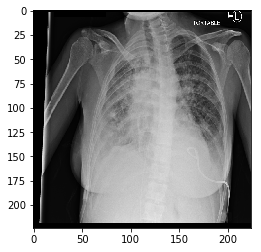

(1, 224, 224, 3)

-- RANDOM --
image_batch.shape: (1, 224, 224, 3)
layer.input_shape: (None, 224, 224, 3)
up_data.shape: (1, 1, 111, 111, 32)
(3, 3, 3, 32)


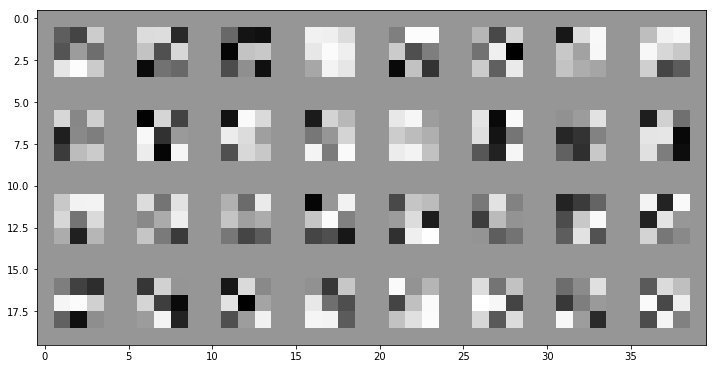

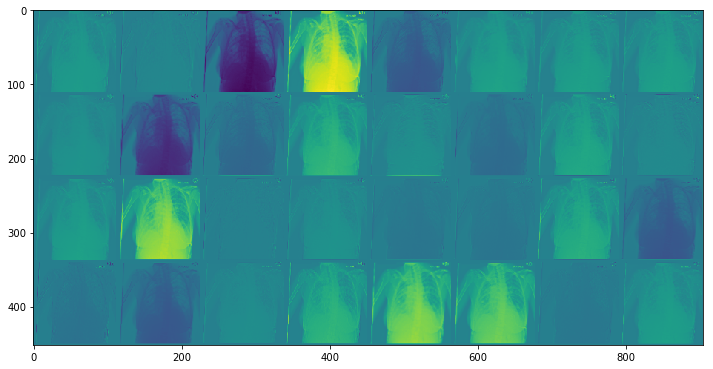

layer.output_shape[1:]: (111, 111, 32)
down_data.shape: (1, 1, 111, 111, 3)


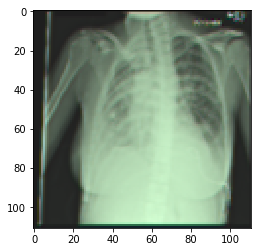

-- IMAGENET --
image_batch.shape: (1, 224, 224, 3)
layer.input_shape: (None, 224, 224, 3)
up_data.shape: (1, 1, 111, 111, 32)
(3, 3, 3, 32)


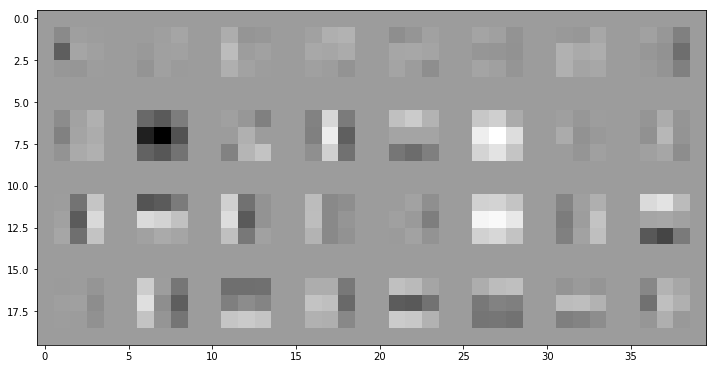

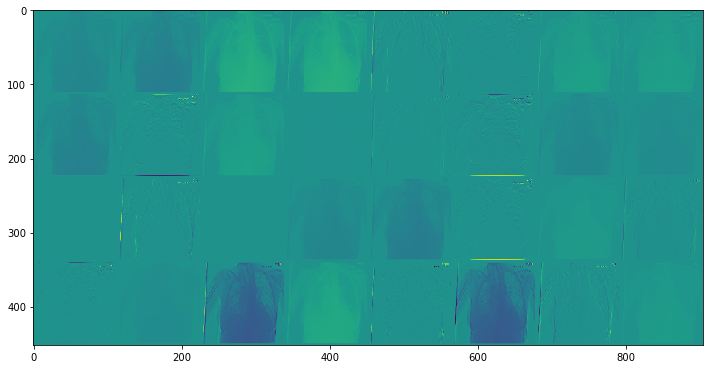

layer.output_shape[1:]: (111, 111, 32)
down_data.shape: (1, 1, 111, 111, 3)


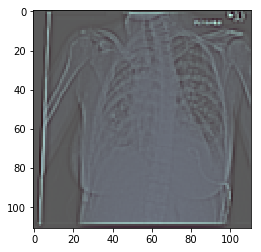

-- TUBERCULOSIS --
image_batch.shape: (1, 224, 224, 3)
layer.input_shape: (None, 224, 224, 3)
up_data.shape: (1, 1, 111, 111, 32)
(3, 3, 3, 32)


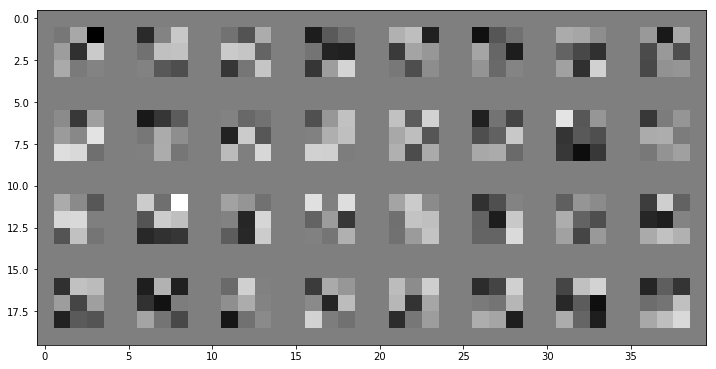

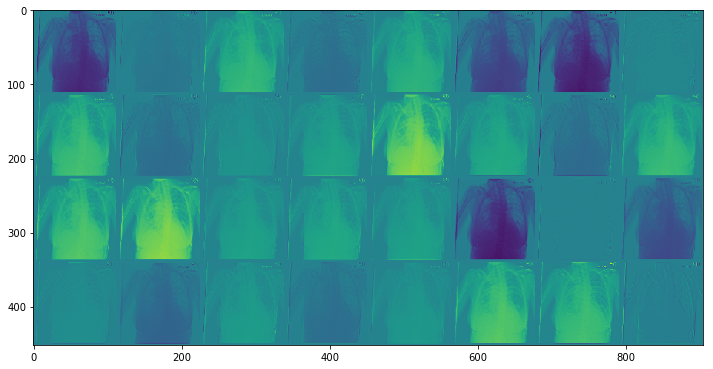

layer.output_shape[1:]: (111, 111, 32)
down_data.shape: (1, 1, 111, 111, 3)


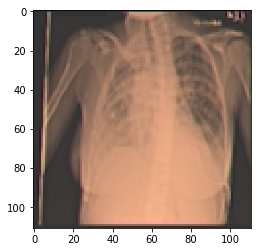

In [50]:
image_batch, _ = get_random_image(X_test)
print(image_batch.shape)
print()
print("-- RANDOM --")
dconv(model_random_topless,image_batch)
print("-- IMAGENET --")
dconv(model_imagenet_topless,image_batch)
print("-- TUBERCULOSIS --")
dconv(model_tuberculosis_topless,image_batch)

<a id="section-lessons-learned"></a>
#### Lessons learned #### 

- __Transfer Learning:__  Making use of pre-trained weights from popular datasets like ImageNet, __[MS COCO](http://cocodataset.org)__, etc... is no better than "random" with respect to particular domains (i.e., chest x-ray images). Essentially, the "top" (final "dense"/fully-connected) layer is doing all of the work; the weights from earlier layers are not better than "random". That being said, using pre-trained weights from the same domain (again, chest x-ray images) albeit a different disease category *can* be useful. However, if this is the approach being taken, then it is best to not *freeze* the layers (that is, enable __[backpropagation](https://www.nature.com/articles/323533a0)__ and update the pre-trained weight values). The [visualizations] above, especially the __[CAM](http://cnnlocalization.csail.mit.edu/)__ output of the final convolutional layer demonstrate that the pre-trained ImageNet weights result in an activation that is often not even in the lung cavity (and thus not actually activating on the disease indicators). Whereas the corresponding CAM output of the final conv layer with the pre-trained Tuberculosis weights does activate on potential disease indicators. I'm confident that with more compute resources (meaning longer training) loss/accuracy would have improved albeit not enough to warrant *freezing* the layers.
***
- __Inputs:__ 
 - Data preparation is the majority of the work! It has been suggested that data preparation is 80+% of a Machine Learning project
 - A "balanced" training set is critical for more accurate classification. More on this in [Potential improvements](#section-potential-improvements)
 - Data augmentation: For the Transfer Learning effort, I did not augment the data to *upsample* (because I already had the max # of training samples than I could make use of for training due to computational resource constraints. However, w.r.t. to the DenseNet OvA binary classifier for "Pulmonary Fibrosis" I was able to upsample the original 1686 images 5x for a total of 8430 class samples. To understand how significant this upsampling was to the results, consider that accuracy was 60% when training OvA on the original 1686 images against a random sample of 1686 images from all other categories (including "No Finding"). With the 5x data augmentation (1686 -> 8430 samples), accuracy improved to 95%!
 - Multi-class classification vs. multiple one-vs-all (OvA; a.k.a. one-vs-rest) binary classifications: Theoretically speaking, there shouldn't be a significant difference in results between a single multi-class classifier or multiple OvA binary classifiers. That being said, I did observe remarkably better results when comparing accuracy of classifying chest x-rays with a OvA binary classifier as opposed to a multi-class softmax classifier. I did some preliminary investigation into why this may be the case, but I don't have any meaningful answers. It could be the TensorFlow implementation of the __[tf.nn.softmax_cross_entropy_with_logits](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)__ method, or it could be that I stopped training too soon with the multi-class classifier (I don't think that this was the case as the validation loss was significantly diverging from training loss. However, I didn't augment the data 5x # of samples as I did with the binary classifier; this is because I do not have the computer resources to train the multi-class classifier with a dataset of that magnitude), or it could be that for this particular dataset there was a significant amount of uncertainty which resulted in close, but incorrect results. For example, if a test sample is correctly classified by the binary classifier albeit with very low confidence (~0.5), then it may've been misclassified altogether w.r.t. to multi-class classification. Others have commented: "several classification algorithms are designed specifically for the 2-class problem, where the response is modeled as the outcome of a Bernouilli trial" (https://stats.stackexchange.com/a/162274). Historically, multi-class classification has been shown to yield better results than multiple binary classifiers (although, multiple binary classifiers have other advantages - specifically, time to train). However, Rifkin and Klautau demonstrated that OvA is as accurate as any other approach [http://www.jmlr.org/papers/v5/rifkin04a.html].
 - Grayscale vs. RGB: There is some debate amongst practitioners as to whether color inputs provide significantly more amount of information (more than the 24 bit to 8 bit difference in channel information) for the neural network. With Transfer Learning, it is a good practice to match the input parameters used to pre-train the weights (i.e., dimensions/pixel-size, color channels). While training from scratch with the Tuberculosis dataset, I did not observe a notable decrease in accuracy, but I also did not notice any significant increase in performance. In order to keep the evaluation comparisons more consistent, I went with RGB because of the ImageNet dataset.
***
- __Interpreting results:__ 
 - [Visualization](#section-visualize-layer-output): It's very important to visualize saliency/activation maps to better understand what the model is "focusing" on. If you simply look at evaluation metrics like accuracy and loss, then you will not understand the what is happening w.r.t. the model.
 - [Confusion Matrix](#section-confusion-matrix): W.r.t. to multi-class classification, a confusion matrix is very helpful to understand whether a particular category (or a few) are the source of most of your errors.

***
- __Training:__ 
 - __Hyperparameters:__ 
   - _Optimizer:_ Initially, I selected the Stochastic Gradient Descent (SGD) optimizer (for tradition sake?), and with it various values of *momentum* (i.e., 9e-1 or 0.9) and lots of variations of both exponential and linear *decay*. However, I also compared the best SGD results against those with the Adam optimizer (https://arxiv.org/abs/1412.6980) since Adam is a common choice among practitioners. With Adam, the model produced significantly better results - likely a result of the way that Adam auto-calculates momentum and decay, and "computes adaptive learning rates" (An overview of gradient descent optimization algorithms: http://ruder.io/optimizing-gradient-descent/index.html).
   - _Loss Function:_ For multi-class classification, standard practice is to select categorical __[cross entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression)__. 
   - _Learning Rate:_ Genearlly speaking, the goal is to find the highest learning rate where loss continues to consistently improve. There wasn't any need to run a Grid Search to sweep for best learning rate - it was quick enough to discover manually (after only a few epochs). Standard practice is to follow the hyperparameters recommended in the published paper accompanying the particular model + optimizer that you're using. In this case (Inception-ResNet-v2 with the Adam optimizer), that is a learning rate of 10e-4 (0.001). However, I found that the model converged much more quickly with a higher learning rate of 10e-2 (0.1).  
  - __Early stopping:__ Whether in the cloud or on a local system, training a model is expensive (both in terms of time and money). With Early stopping, you can kind of "set it and forget it", where your training will stop early if it is not improving per a particular metric (i.e., minimizing loss). However, there was more than 1 occassion where I had set the early stopping criteria too low (that is, requiring that loss improve after only a few epochs), and thus training would top-out early, when it had not fully converged. Like hyperparameters, you need to try various criteria to determine the approprate early stopping requirements per each model and dataset. I find that it is also good practice to set the early stopping critera to be the # of epochs in at least 1 full pass through the input dataset. If there is no improvement after a complete pass, then it may certainly be stopped. Otherwise, you can quickly gain an intuition about whether the validation/test loss is diverging from the training loss, and then force an early stop manually.

<a id="section-potential-improvements"></a>
#### Potential improvements #### 

- __"Balance" the training set.__ If we take a look at a bar chart showing the distribution of our training set, we find that over 40% of our training samples belong to a single category ("No Finding"), and the top 4 categories make up nearly 75% of the entire dataset.

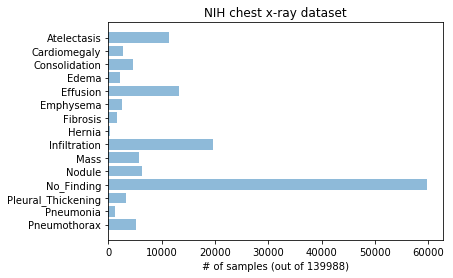

In [49]:
fig = plt.figure(figsize=(6,4))
plt.rcdefaults()
disease_categories = ('Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'No_Finding', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax')
y_pos = np.arange(len(disease_categories))
num_samples = [11420,2744,4620,2280,13174,2491,1669,225,19671,5689,6260,59809,3351,1339,5245]
plt.barh(y_pos, num_samples[::-1], align='center', alpha=0.5)
plt.yticks(y_pos, disease_categories[::-1])
plt.xlabel('# of samples (out of 139988)')
plt.title('NIH chest x-ray dataset')
plt.show()

- __How to balance the training set?__
 - SMOTE: Chawla, et. al. propose "an over-sampling approach in which the minority class is over-sampled by creating “synthetic” examples rather than by over-sampling with replacement ... The minority class is over-sampled by taking each minority class sample and introducing synthetic examples along the line segments joining any/all of the k minority class nearest neighbors. Depending upon the amount of over-sampling required, neighbors from the k nearest neighbors are randomly chosen ... Synthetic samples are generated in the following way: Take the difference between the feature vector (sample) under consideration and its nearest neighbor. Multiply this difference by a random number between 0 and 1, and add it to the feature vector under consideration. This causes the selection of a random point along the line segment between two specific features. This approach effectively forces the decision region of the minority class to become more general." (https://arxiv.org/abs/1106.1813)
 - In their paper about Lung Nodule recognition, Sui, et. al., apply SMOTE to the minority class along with undersampling of the majority class to achieve "average classification accuracy is more than 92.94% (up from ~75% on the initial unbalanced dataset using SVM). It is suitable for the application in clinical lung cancer CAD system." (https://europepmc.org/abstract/MED/25977704)
 - Find an appropriate average of categories with similar distributions (i.e., 3500 samples per category). Then divide classes which have significantly more samples (i.e., the top 4 categories) into sub-categories (i.e., (A1..A3), (E1..E3), (I1..I5), (NF1..NF17)) and train the model include prediction on those categories. Then average all of those sub-categories together for a single prediction of the parent category.
 - Remove any significantly underrepresented categories ("Hernia", in this case)
 - Alternatively, we could boost the # of samples in each disease category against the "No Finding" category. Similary to work undertaken by Shin, et. al., we could "balance the number of samples for disease cases by random cropping during training, where each image of a diseased case is augmented at least 4 times." (https://arxiv.org/abs/1603.08486)

*Example of balancing the training set. The "Hernia" category should be dropped since we have so few samples, and we temporarily remove the "No Findings" category to calculate IQR*

In [ ]:
def get_num_label_batches(per_label_count):
    num_label_batches = []
    q75, q25 = np.nanpercentile(per_label_count, [75,25])
    print(q75)
    print(q25)
    iqr = q75-q25
    print(q75+iqr*1.5)
    print(q25-iqr*1.5)
    for ii in range(len(per_label_count)):
        count = per_label_count[ii]
        if count >= (iqr*2):
            num_label_batches.append(int(count/iqr))
        else:
            num_label_batches.append(0)
    return int(iqr), num_label_batches

print(directories)
print(per_label_count)
# temporarily remove "No Findings" since it's an extreme outlier, then calculate IQR
tmp_label = directories[7]
del directories[7]
tmp_label_count = per_label_count[7]
del per_label_count[7]
print(directories)
print(per_label_count)
label_batch_size, num_label_batches = get_num_label_batches(per_label_count)
print(label_batch_size)
print(num_label_batches)
directories.append(tmp_label)
per_label_count.append(tmp_label_count)
print(directories)
print(per_label_count)

*Resample directories based on IQR calculations*

In [ ]:
def get_label_directories_resampled(directories, label_batch_size, num_label_batches):
    directories_resampled = set()
    directories_resampled_abs = set()
    new_directories = []
    for ii in range(len(num_label_batches)):
        label = directories[ii]
        num_batches = num_label_batches[ii]
        if num_batches != 0:
            for jj in range(num_batches):
                src_train_dir = os.path.join(img_path,"train",label)
                src_valid_dir = os.path.join(img_path,"valid",label)
                src_test_dir = os.path.join(img_path,"test",label)
                new_label = label + "_" + str(jj+1)
                dst_train_dir = os.path.join(img_path,"train",new_label)
                dst_valid_dir = os.path.join(img_path,"valid",new_label)
                dst_test_dir = os.path.join(img_path,"test",new_label)
                try:
                    if not os.path.exists(dst_train_dir):
                        #print("mkdir: " + dst_train_dir)
                        os.makedirs(dst_train_dir)
                    if not os.path.exists(dst_valid_dir):
                        #print("mkdir: " + dst_valid_dir)
                        os.makedirs(dst_valid_dir)
                    if not os.path.exists(dst_test_dir):
                        #print("mkdir: " + dst_test_dir)
                        os.makedirs(dst_test_dir)
                    all_img_paths = glob.glob(os.path.join(src_train_dir,"*.*"))
                    np.random.shuffle(all_img_paths)
                    batch_count = int(label_batch_size)
                    batch_files = all_img_paths[:batch_count]
                    #print(len(batch_files))
                    for batch_file in batch_files:
                        batch_file_abs = os.path.join(os.getcwd(),batch_file)
                        #print("move: '" + batch_file_abs + "' to: '" + dst_dir)
                        shutil.move(batch_file_abs, dst_train_dir)
                    new_directories.append(new_label)
                    directories_resampled.add(label)
                    src_train_dir_abs = os.path.join(os.getcwd(),src_train_dir)
                    src_valid_dir_abs = os.path.join(os.getcwd(),src_valid_dir)
                    src_test_dir_abs = os.path.join(os.getcwd(),src_test_dir)
                    directories_resampled_abs.add(src_train_dir_abs)
                    directories_resampled_abs.add(src_valid_dir_abs)
                    directories_resampled_abs.add(src_test_dir_abs)
                except FileNotFoundError:
                    print("FileNotFoundError: " + src_dir)
                else:
                    None
    return new_directories, list(directories_resampled), list(directories_resampled_abs)

def merge_directories_list(directories, new_directories, directories_resampled):
    resampled_directories = list(directories)
    resampled_directories = [directory for directory in resampled_directories if directory not in directories_resampled]
    for directory in new_directories:
        resampled_directories.append(directory)
    return resampled_directories

print(directories)
print(label_batch_size)
print(num_label_batches)
new_directories, directories_resampled, directories_resampled_abs = get_label_directories_resampled(directories, label_batch_size, num_label_batches)
print(directories_resampled_abs)
for directory in directories_resampled_abs:
    #print(directory)
    shutil.rmtree(directory)
print(new_directories)
print(directories_resampled)
resampled_directories = merge_directories_list(directories, new_directories, directories_resampled)
print(resampled_directories)

In [ ]:
print(resampled_directories)
resampled_per_label_count = get_per_label_count(resampled_directories) 
print(resampled_per_label_count)

- __"Masking"__. Isolate meaningful information; train only within the ribcage boundary, on the lungs, without distraction (clavicle, sternum, stomach, medical wires, etc...). The differences between lung diseases as diagnosed by chest x-ray images is very subtle. Lo, et. al. report on these difficulties: "Studies in the use of chest radiographs for the detection of lung nodules [1][2] have indicated that even with highly skilled and highly motivated radiologists who working with high quality chest radiographs, only 68% of all retrospectively detected lung cancers were detected prospectively when read by one reader, and only 82% were detected by two readers." [3]
   1. Heelan, RT, Flechinger, BJ, Melamed, MR, et al (1984) Non small cell lung cancer: Results of the
New York screening program. Radiology, 151, 289-293.
   1. Stitik, FP, Tockman, MS, & Khouri, NF, (1985). Chest radiology. In A.B. Miller (Ed.), Screening
for Cancer, (pp. 163-19 1) New York: Academic Press.
   1. Lo, et. al.

 - With Mask R-CNN, He, et. al. take an approach that "is conceptually simple: Faster R-CNN has two outputs for each candidate object, a class label and a bounding-box offset; to this we add a third branch that out- puts the object mask. Mask R-CNN is thus a natural and intuitive idea. But the additional mask output is distinct from the class and box outputs, requiring extraction of much finer spatial layout of an object. Next, we introduce the key elements of Mask R-CNN, including pixel-to-pixel alignment, which is the main missing piece of Fast/Faster R-CNN." (https://arxiv.org/abs/1703.06870)
 - __[MatterPort](https://matterport.com/)__ provides an implementation of the Mask R-CNN model by He, et. al.: https://github.com/matterport/Mask_RCNN

For instance, while visualizing some of the model predictions, we find that some activations are occurring on features that are not actually relevant. They may help to predict for the particular training/validation set, but of course these features will not generalize to new inputs. This was most evident when the model predicts "Consolidation" as a result of considering the presence wires to be the most important feature. In other cases, activations occurred on text/labels within the chest x-ray image (as opposed to within the acutal lung cavity).
 
*Example of learning a "red herring" feature*

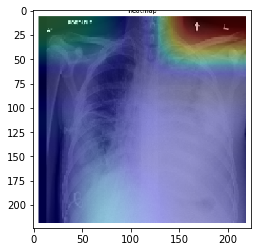

In [44]:
image_batch = get_image_batch("notebook/heatmap-on-text-mistake.png",True)

*Example of "masked" lungs*

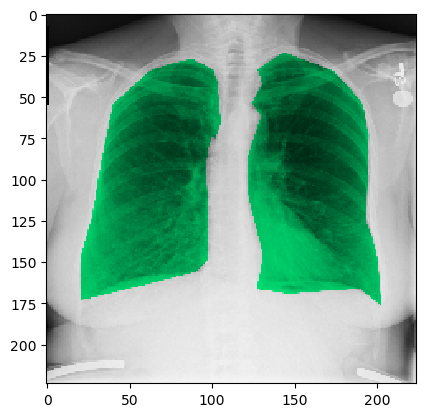

In [50]:
image_batch = get_image_batch("notebook/00001998_000-masked.png",True)

- __Mimic human techniques__. Lo, et. al. continue: "In detecting lung nodules, radiologists first search for suspected areas on the chest radiograph looking for bright round objects within the rib-cage boundary. Next each suspected area is examined to compare the contrast information of the bright spot to the local background. Sometimes a radiologist uses several viewing positions to look at the area. When using a workstation, the radiologist may utilize zoom and "window and level" functions to get different views of roundness and contrast information for the suspected areas. The differentiation between a nodule and a vessel spot can be very difficult for human eyes to discern but is often based on the presence of projections from the round shape and its relative contrast compared to the background and to other vessels." Mimicking this appropach may entail more preprocessing to enhance "roundness and contrast information", or applying different pooling techniques to weight "suspect areas" more significantly, or it may mean to take multiple passes and train the first model to find "suspect areas", and then training a second model to classify based only on "suspect area" inputs.
***
- __Higher image resolution__. The images in the NIH chest x-ray dataset are 1 MB or smaller. When classifying objects that have significantly distinct and abstract shapes (dog vs. car), this is more than enough pixels (and why many of the pre-trained networks available, like ImageNet, are often trained with inputs of 299x299 or 224x224. In the case of a dataset like ImageNet, the minimal trade-off in accuracy is worth the boost in (training) performance.  However, this is not the case when we're attempting to classify something as specific as types of lung diseases based on chest x-ray images. In cases like this where the minutia matters, we want as high a resolution as computationally feasible.

<a id="section-densenet"></a>
## DenseNet ##

Based on the somewhat lackluster results of the Transfer Learning investigation, and inspired by Stanford ML Group's __[CheXNet](https://stanfordmlgroup.github.io/projects/chexnet/)__, I also decided to train a DenseNet [1] network to perform binary classification on the same NIH chest x-ray [dataset](#section-datasets), albeit on a single category ("Pulmonary Fibrosis"). In this case, the binary classification is a one-vs-all (a.k.a. __[one-vs-rest](https://en.wikipedia.org/wiki/Multiclass_classification#One-vs.-rest)__) approach for the lung disease category: "Pulmonary Fibrosis"; samples from this single class are taken against a random sample of the other 14 categories (including "No Finding"). This approach seemed to have achieved near state of the art results, with an __[AUROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve)__ of far greater than 0.05 of previously published results [2]. Due to my surprise, I immediately gathered another distinct chest x-ray dataset ([Indiana University](#section-datasets) - IU), which also included Pulmonary Fibrosis examples, and I tested that dataset. The model failed terribly!

Initially, I *downsampled* the _*ALL*_ category to have 1686 samples (equal to the number of "Pulmonary Fibrosis" samples). Training Loss and Validation Loss were tracking well, and the model converged to a low loss and surprisingly high accuracy. Due diligence was performed: I generated a Confusion Matrix, compiled all the usual statistics, and I calculated ROC/AUROC. Everything looked great on the Test Set! Then I ran the model against a distinct dataset (IU) containing only images labeled with Pulmonary Fibrosis, and each prediction was incorrect (predicted as a False Negative). At this point, it was clear that I needed a lot more training data. I re-ran the same 2 Test Sets, but this time with a model which had been trained with 3x the # of samples. The original images were *upsampled* using a combination of data augmentation techniques: horizontal flipping, cropping, and shearing. Results per the distribution (NIH) test set were worse than the previous model, but better per the IU dataset. However, better still was very poor (see results below).

I have made the [weights](#section-weights) publicly available, I have published my DenseNet implementation details as a __[public Kaggle Kernel](https://www.kaggle.com/zdmc23/nihdensenet/)__, and I have also developed a Web Service (__https://zdmc.info/pulmonary-fibrosis__) to test individual samples from different datasets, and to experiment with Dynamically Expandable Networks (DENs) [3].

 1. Huang, et. al. (2016). Densely Connected Convolutional Networks. https://arxiv.org/abs/1711.05225
 1. Rajpukar, et. al. (2017). CheXNet: Radiologist-Level Pneumonia Detection on Chest X-Rays with Deep Learning, 4. https://arxiv.org/abs/1711.05225
 1. Lee, et. al. (2017). Lifelong Learning with Dynamically Expandable Networks. https://arxiv.org/abs/1708.01547v2

#### Preprocessing the Dataset ####

*Python script auto-create directories for each of the disease categories, and create symlinks for each image under the appropriate disease category (per Data_Entry_2017.csv). This assumes that the NIH dataset has been downloaded and the various image zip files (images_001.zip through images_012.zip) have been unzip'd to "data/images"* 

In [ ]:
import csv

def create_label_directories(csv_filename, img_path, is_one_v_all=False, one_v_all_label="Fibrosis"):
    directories = set()
    with open(csv_filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(csvfile) # skip header row
        for row in reader:
            img_filename = str(row[0])
            labels = str(row[1])
            for label in labels.split('|'):
                if (is_one_v_all is True) and (label != one_v_all_label):
                    label = "ALL"
                src_file = os.path.join(img_path,img_filename)
                label = "_".join(label.split())
                dst_train_dir = os.path.join(img_path,"train",label)
                dst_train_file = os.path.join(dst_train_dir,img_filename)
                dst_valid_dir = os.path.join(img_path,"valid",label)
                dst_test_dir = os.path.join(img_path,"test",label)
                if not os.path.exists(dst_train_dir):
                    os.makedirs(dst_train_dir)
                    directories.add(label)
                if not os.path.exists(dst_valid_dir):
                    os.makedirs(dst_valid_dir)
                if not os.path.exists(dst_test_dir):
                    os.makedirs(dst_test_dir)
                src_file_abs = os.path.join(os.getcwd(),src_file)
                dst_train_file_abs = os.path.join(os.getcwd(),dst_train_file)
                #print("copy: " + src_file_abs + " to: " + dst_train_file_abs)
                if not os.path.exists(dst_train_file_abs):
                    os.symlink(src_file_abs, dst_train_file_abs)
    return list(directories)

is_one_v_all = True
one_v_all_label = "Fibrosis"
print(img_path)
directories = create_label_directories("data/Data_Entry_2017.csv", img_path, is_one_v_all, one_v_all_label)
print(directories)

*Upsample*

In [ ]:
import subprocess

def upsample(directories, per_label_count, iqr):
    for ii in range(len(per_label_count)):
        label = directories[ii]
        count = per_label_count[ii]
        if count < iqr:
            offset = iqr-count
            subprocess.call(['./batch-augment.sh', os.path.join(os.getcwd(),img_path,"train",label), str(offset)])
    return get_per_label_count(directories)

print(directories)
print(per_label_count)
print(label_batch_size)
per_label_count_upsampled = upsample(directories, per_label_count, label_batch_size)
print(per_label_count_upsampled)

*Downsample*

In [ ]:
def downsample(directories, per_label_count):
    label_idx = np.argmin(per_label_count)
    #print(label_idx)
    downsample_count = per_label_count[label_idx]
    #print(downsample_count)
    for ii in range(len(per_label_count)):
        label = directories[ii]
        src_train_dir = os.path.join(img_path,"train",label)
        all_img_paths = glob.glob(os.path.join(src_train_dir,"*.*"))
        np.random.shuffle(all_img_paths)
        if len(all_img_paths) != downsample_count:
            imgs_to_remove = all_img_paths[downsample_count:]
            #print(len(imgs_to_remove))
            for file in imgs_to_remove:
                file_abs = os.path.join(os.getcwd(),file)
                #print("remove file: " + file_abs)
                os.remove(file_abs)
    return get_per_label_count(directories)

print(directories)
print(per_label_count)
print(label_batch_size)
per_label_count_downsampled = downsample(directories, per_label_count_upsampled, label_batch_size)
print(per_label_count_downsampled)

#### Load Dataset (batches) ####

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import preprocess_input

train_datagen = ImageDataGenerator(
    #rescale=1./255,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True, 
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
    'data/images-fibrosis-ova/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')
    #color_mode='grayscale')

validation_generator = test_datagen.flow_from_directory(
    'data/images-fibrosis-ova/valid',
    target_size=(img_height, img_width),
    batch_size=batch_size, #val_batch_size,
    class_mode='categorical')
    
test_generator = test_datagen.flow_from_directory(
    'data/images-fibrosis-ova/test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 16188 images belonging to 2 classes.
Found 336 images belonging to 2 classes.
Found 336 images belonging to 2 classes.


#### Loading the Model ####

In [3]:
from keras.applications.densenet import DenseNet121
model_densenet = DenseNet121(include_top=True, weights=None, input_shape=(img_width,img_height,3), classes=2)
model_densenet3x = DenseNet121(include_top=True, weights=None, input_shape=(img_width,img_height,3), classes=2)
model_densenet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

#### Compile the Model ####

*For comparison purposes, we use a DenseNet121 network with SGD and the same hyperparameters as used in the Stanford ML Group CheXNet paper [1], which in turn used the same hyperparameters proposed in the original Huang DenseNet paper [2]. The only hyperparameter that we can not replicate in Keras is weight decay*

 1. Rajpukar, et. al. (2017). CheXNet: Radiologist-Level Pneumonia Detection on Chest X-Rays with Deep Learning. https://arxiv.org/abs/1711.05225
 1. Huang, et. al. (2016). Densely Connected Convolutional Networks, https://arxiv.org/abs/1711.05225

In [4]:
# only missing -> cmd:option('-weightDecay', 1e-4, 'weight decay')
from keras import optimizers
model_densenet.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True), metrics=['accuracy'])
model_densenet3x.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True), metrics=['accuracy'])

#### Load weights ####

In [5]:
model_densenet.load_weights('weights.best.DenseNet121-nih-one-v-all-fibrosis.20180305.hdf5')
model_densenet3x.load_weights('weights.best.DenseNet121-nih-one-v-all-fibrosis.20180312-3x.hdf5')

#### Callbacks ####

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
filepath="weights.best.DenseNet121-nih-one-v-all-fibrosis.20180306.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min') #mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=batch_size)
callbacks_list = [checkpoint,early_stopping]

#### Train the Model ####

In [ ]:
nb_train_samples = 16188
nb_validation_samples= 336 
epochs = int(nb_train_samples/batch_size)*2
history = model_densenet.fit_generator(
    train_generator,
    steps_per_epoch=batch_size, #nb_train_samples/batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=batch_size, #nb_validation_samples/batch_size, #val_batch_size,
    callbacks=callbacks_list,
    verbose=1)

#### Visual training history ####

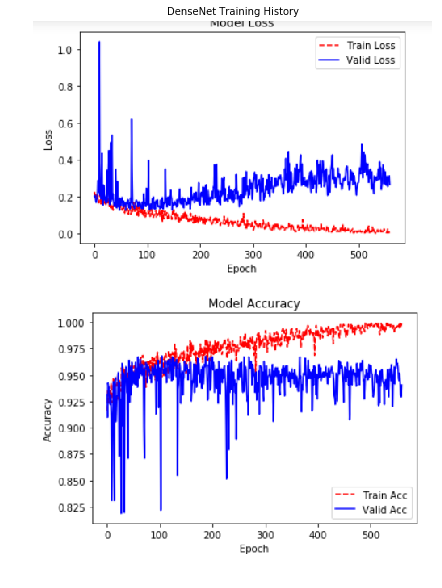

In [11]:
#plot_history(history)
fig = plt.figure(figsize=(10,10))
plot_img("notebook/densenet-graphs.png","DenseNet Training History",1,1,False)
plt.show()

#### Model Evaluation ####

In [7]:
nb_test_samples = 336
steps = math.ceil(nb_test_samples/batch_size)
print(steps)

11


In [9]:
scores = model_densenet.evaluate_generator(test_generator, steps=steps, max_queue_size=10, workers=1, use_multiprocessing=False)
print("score = Loss: %f, Acc@1: %.2f" % (scores[0],scores[1]))
scores = model_densenet3x.evaluate_generator(test_generator, steps=steps, max_queue_size=10, workers=1, use_multiprocessing=False)
print("score = Loss: %f, Acc@1: %.2f" % (scores[0],scores[1]))

score = Loss: 0.132701, Acc@1: 0.95
score = Loss: 1.262834, Acc@1: 0.59


*Our first model (with less samples, but no augmentation) is performing extremely well - probably too well (as we will see when we test a distinct Pulmonary Fibrosis dataset)*

#### Predictions ####

In [11]:
#print(test_generator.classes)
def get_predictions(model,generator):
    preds = np.zeros((0,2))
    y_test = np.zeros((0,2))
    step_count = 0
    for batch_x, batch_y in generator:
        if step_count < steps:
            batch_preds = model.predict(batch_x)
            #print(batch_preds.shape)
            preds = np.vstack((preds,batch_preds))
            #print(batch_y)
            y_test = np.vstack((y_test,batch_y))
            step_count = step_count + 1
        else:
            break
    return preds, y_test
    
preds, y_test = get_predictions(model_densenet,test_generator)
print(preds.shape)
print(y_test.shape)
preds3x, y_test3x = get_predictions(model_densenet3x, test_generator)
print(preds3x.shape)
print(y_test3x.shape)

(336, 2)
(336, 2)


#### Confusion Matrix and Statistics ####

In [12]:
import itertools
from sklearn.metrics import confusion_matrix

def print_statistics(cm):
    tn, fp, fn, tp = cm.ravel()
    # TP
    print("TP: " + str(tp))
    # TN
    print("TN: " + str(tn))
    # FP
    print("FP: " + str(fp))
    # FN
    print("FN: " + str(fn))
    # TPR
    recall = tp/(tp+fn)
    print("TPR/recall: " + str(recall))
    # TNR
    specificity = tn/(tn+fp)
    print("TNR/specificity: " + str(specificity))
    # PPV
    precision = tp/(tp+fp)
    print("PPV/precision: " + str(precision))
    # NPV
    npv = tn/(tn+fn)
    print("NPV/negative predictive value: " + str(npv))
    # FNR
    miss_rate = 1-recall
    print("FNR/false negative rate: " + str(miss_rate))
    # FPR
    fall_out = 1-specificity
    print("FPR/false positive rate: " + str(fall_out))
    # FDR
    fdr = 1-precision
    print("FDR/false discovery rate: " + str(fdr))
    # FOR
    fomr = 1-npv
    print("FOR/false ommission rate: " + str(fomr))
    # F1
    f1 = 2*((precision*recall)/(precision+recall))
    print("F1 score: " + str(f1))
    # accuracy
    acc = (tp+tn)/(tp+tn+fp+fn)
    print("Accuracy: " + str(acc))
    # Matthews correlation coefficient (MCC)
    mcc = (tp*tn-fp*fn)/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    print("MCC/Matthews correlation coefficient: " + str(mcc))
    # Informedness or Bookmaker Informedness (BM)
    bm = recall+specificity-1
    print("BM/Bookmaker Informedness: " + str(bm))
    # Markedness (MK)
    mk = precision+npv-1
    print("MK/Markedness: " + str(mk))
    
    return fall_out, recall

# credit: https://github.com/scikit-learn/scikit-learn/blob/master/examples/model_selection/plot_confusion_matrix.py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    s = [['TN','FP'], ['FN', 'TP']]
    #s = [['TP','FN'], ['FP', 'TN']]
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(2):
        for j in range(2):
            plt.text(j,i, (str(s[i][j])+" = "+str(format(cm[i][j],fmt))),horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

TP: 155
TN: 165
FP: 3
FN: 13
TPR/recall: 0.9226190476190477
TNR/specificity: 0.9821428571428571
PPV/precision: 0.9810126582278481
NPV/negative predictive value: 0.9269662921348315
FNR/false negative rate: 0.07738095238095233
FPR/false positive rate: 0.017857142857142905
FDR/false discovery rate: 0.01898734177215189
FOR/false ommission rate: 0.0730337078651685
F1 score: 0.950920245398773
Accuracy: 0.9523809523809523
MCC/Matthews correlation coefficient: 0.906369000249817
BM/Bookmaker Informedness: 0.9047619047619047
MK/Markedness: 0.9079789503626796


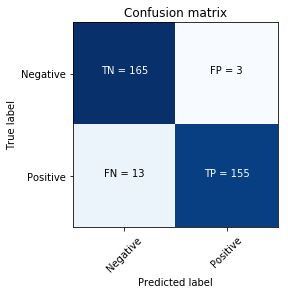

In [13]:
trues = y_test 
y_trues = [np.argmax(ii) for ii in trues]
y_preds = [np.argmax(ii) for ii in preds]

cm = confusion_matrix(y_trues, y_preds)
fpr, tpr = print_statistics(cm)

plt.figure()
plot_confusion_matrix(cm, classes=['Negative','Positive'], title='Confusion matrix')
plt.show()

TP: 71
TN: 129
FP: 39
FN: 97
TPR/recall: 0.4226190476190476
TNR/specificity: 0.7678571428571429
PPV/precision: 0.6454545454545455
NPV/negative predictive value: 0.5707964601769911
FNR/false negative rate: 0.5773809523809523
FPR/false positive rate: 0.2321428571428571
FDR/false discovery rate: 0.3545454545454545
FOR/false ommission rate: 0.42920353982300885
F1 score: 0.5107913669064748
Accuracy: 0.5952380952380952
MCC/Matthews correlation coefficient: 0.20295484162576735
BM/Bookmaker Informedness: 0.19047619047619047
MK/Markedness: 0.21625100563153676


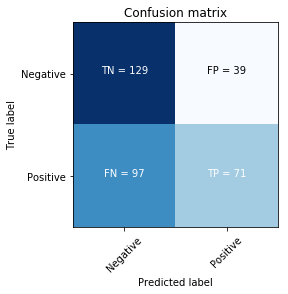

In [14]:
trues3x = y_test3x
y_trues3x = [np.argmax(ii) for ii in trues3x]
y_preds3x = [np.argmax(ii) for ii in preds3x]
cm3x = confusion_matrix(y_trues3x, y_preds3x)
fpr3x, tpr3x = print_statistics(cm3x)

plt.figure()
plot_confusion_matrix(cm3x, classes=['Negative','Positive'], title='Confusion matrix')
plt.show()

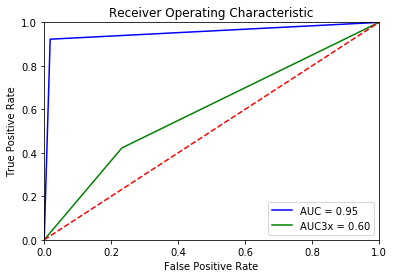

In [15]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_trues, y_preds)
fpr3x, tpr3x, threshold3x = roc_curve(y_trues3x, y_preds3x)
roc_auc = auc(fpr,tpr)
roc_auc3x = auc(fpr3x,tpr3x)

# credit: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr3x, tpr3x, 'g', label = 'AUC3x = %0.2f' % roc_auc3x)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Test a different dataset (IU dataset) ####

*A completely different dataset - 26 "pulmonary fibrosis" images from the Indiana University [dataset](#section-datasets)*

#### Load Dataset (in-memory) ####

In [17]:
def get_data(images_dir):
    imgs = []
    labels = []
    all_img_paths = glob.glob(os.path.join(images_dir, '*.*'))
    #np.random.shuffle(all_img_paths)
    for img_path in all_img_paths:
        img = load_img(img_path, target_size=(img_width, img_height))
        img = img_to_array(img)
        img = preprocess_input(img) 
        imgs.append(img)
        if "fibrosis" in img_path.lower():
            labels.append([0,1])
        else:
            labels.append([1,0])
    return np.array(imgs), np.array(labels)
                                           
X_indiana, y_indiana = get_data("data/images-indiana-fibrosis/test/Fibrosis")
print(X_indiana.shape)
print(y_indiana.shape)

(18, 224, 224, 3)
(18, 2)


#### Evaluate the Model, on the IU dataset ####

In [18]:
scores = model_densenet.evaluate(X_indiana, y_indiana)
print("score = Loss: %f, Acc@1: %.2f" % (scores[0],scores[1]))
scores = model_densenet3x.evaluate(X_indiana, y_indiana)
print("score = Loss: %f, Acc@1: %.2f" % (scores[0],scores[1]))

18/18 [==============================] - 0s 20ms/step
score = Loss: 2.603685, Acc@1: 0.00
18/18 [==============================] - 0s 15ms/step
score = Loss: 3.714435, Acc@1: 0.17


*No comment needed. Abysmal accuracy on a distinct Pulmonary Fibrosis dataset*

#### Predictions, on the IU dataset ####

In [19]:
indiana_preds = model_densenet.predict(X_indiana)
print(indiana_preds.shape)
indiana_preds = model_densenet3x.predict(X_indiana)
print(indiana_preds3x.shape)

(18, 2)
(18, 2)


In [20]:
for ii in range(len(indiana_preds)):
    print(indiana_preds[ii])

[0.9554871  0.04451291]
[0.96485513 0.03514481]
[0.95352286 0.04647713]
[0.9829685  0.01703146]
[0.50600725 0.49399275]
[0.8178788  0.18212123]
[0.91936684 0.08063315]
[0.68749017 0.31250983]
[0.969715   0.03028502]
[0.9319257  0.06807435]
[0.54593    0.45406994]
[0.9657192  0.03428078]
[0.992919   0.00708101]
[0.73570675 0.26429328]
[0.97711    0.02288999]
[0.5362986  0.46370143]
[0.93931997 0.06068009]
[0.9592226  0.04077742]


*Based on the certainty of these incorrect predictions, it may be safe to assume that our training was biased towards ALL vs. Fibrosis (even thought the dataset was "balanced")*

In [21]:
for ii in range(len(indiana_preds3x)):
    print(indiana_preds3x[ii])

[0.98588216 0.01411785]
[0.9852278  0.01477222]
[0.22985636 0.7701436 ]
[0.98222417 0.01777578]
[0.55528307 0.4447169 ]
[9.9901175e-01 9.8821544e-04]
[0.82801014 0.1719899 ]
[0.02040187 0.9795981 ]
[0.66973525 0.33026475]
[0.7344189  0.26558107]
[0.07332112 0.9266789 ]
[0.99818784 0.00181217]
[0.98645246 0.01354763]
[9.9994028e-01 5.9711147e-05]
[9.9963760e-01 3.6239377e-04]
[0.9376369  0.06236303]
[9.999145e-01 8.542881e-05]
[0.81110203 0.18889795]


#### Confusion Matrix and Statistics ####

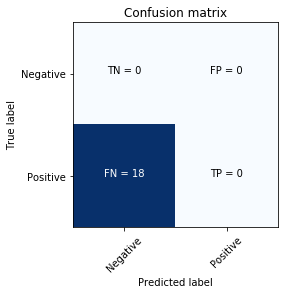

In [27]:
trues = y_indiana
y_trues = [np.argmax(ii) for ii in trues]
preds = indiana_preds
y_preds = [np.argmax(ii) for ii in preds]

cm = confusion_matrix(y_trues, y_preds)
#fpr, tpr = print_statistics(cm)

plt.figure()
plot_confusion_matrix(cm, classes=['Negative','Positive'], title='Confusion matrix')
plt.show()

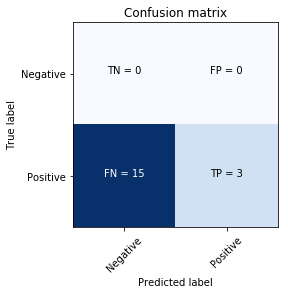

In [28]:
trues3x = y_indiana
y_trues3x = [np.argmax(ii) for ii in trues3x]
preds3x = indiana_preds3x
y_preds3x = [np.argmax(ii) for ii in preds3x]
cm3x = confusion_matrix(y_trues3x, y_preds3x)
#fpr3x, tpr3x = print_statistics(cm3x)

plt.figure()
plot_confusion_matrix(cm3x, classes=['Negative','Positive'], title='Confusion matrix')
plt.show()

#### Going further ####

To continue with the project would mean collecting more data, specifically positive examples of Pulmonary Fibrosis chest x-ray images. Upsampling didn't yield the hoped for result on different datasets, so it may make sense to re-examine the type of data augmentation (i.e., to "shear" or not to shear, that is a question). It would also be interesting to experiment with non-CNN approaches: CapsuleNet [1] or a few Fully-Connected layers, etc...

It would also be interesting to experiment with Dynamically Expandable Networks (DENs) [2]; with a goal of periodically updating the model/network based on new, user-provided (via https://zdmc.info/pulmonary-fibrosis) examples.

1. Sabour, et. al. (2017). Dynamic Routing Between Capsules. https://arxiv.org/abs/1710.09829
2. Lee, et. al. (2017). Lifelong Learning with Dynamically Expandable Networks. https://arxiv.org/abs/1708.01547v2